In [8]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-geometric \
  torch-sparse==latest+cu100 \
  torch-scatter==latest+cu100 \
  torch-cluster==latest+cu100 \
  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.4.0/torch_sparse-latest%2Bcu100-cp37-cp37m-linux_x86_64.whl
  Using cached https://pytorch-geometric.com/whl/torch-1.4.0/torch_scatter-latest%2Bcu100-cp37-cp37m-linux_x86_64.whl
  Using cached https://pytorch-geometric.com/whl/torch-1.4.0/torch_cluster-latest%2Bcu100-cp37-cp37m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.1
    Uninstalling torch-sparse-0.6.1:
      Successfully uninstalled torch-sparse-0.6.1
  Found existing installation: torch-scatter 2.0.4
    Uninstalling torch-scatter-2.0.4:
      Successfully uninstalled torch-scatter-2.0.4
  Found existing installation: torch-cluster 1.5.4
    Uninstalling torch-cluster-1.5.4:
      Successfully uninstalled torch-cluster-1.5.4


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd /content/drive/MyDrive/05.New_DRP3_ge_meth

/content/drive/.shortcut-targets-by-id/1AOejWfAFAbavCAK41tw-ixKRyM9vc3Yj/05.New_DRP3_ge_meth


In [11]:
import numpy as np
import pandas as pd
import sys, os
from sklearn.metrics import roc_auc_score
from random import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from models.gat import GATNet
from models.gat_gcn import GAT_GCN
from models.gcn import GCNNet
from models.ginconv import GINConvNet
from utils import *
import datetime
import argparse


#train

In [12]:
%cd /content/drive/MyDrive/05.New_DRP3_ge_meth

/content/drive/.shortcut-targets-by-id/1AOejWfAFAbavCAK41tw-ixKRyM9vc3Yj/05.New_DRP3_ge_meth


In [13]:


store_path = "/content/drive/MyDrive/05.New_DRP3_ge_meth/Pretrain_DRP/DRP_RS_ge_mut_meth/"
data_path = "/content/drive/MyDrive/05.New_DRP3_ge_meth/recall_moli/create_data/Splitting_data_new/ge_mut_meth/" # data to process
data_processed_path = "/content/drive/MyDrive/05.New_DRP3_ge_meth/recall_moli/create_data/Splitting_data_new/ge_mut_meth/processed/" # data processed
pretrain_model_path = "/content/drive/MyDrive/05.New_DRP3_ge_meth/recall_moli/pretrain_model/ge-mut-meth/model_GINConvNet_GDSC.model" # weight of the model (GIN)

# GINConv model
class GINConvNet(torch.nn.Module):
    def __init__(self, n_output=1,num_features_xd=78, num_features_xt=25,
                 n_filters=32, embed_dim=128, output_dim=128, dropout=0.2):

        super(GINConvNet, self).__init__()

        dim = 32
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.n_output = n_output
        # convolution layers
        nn1 = Sequential(Linear(num_features_xd, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1_xd = Linear(dim, output_dim)

        # 1D convolution on protein sequence  # mut features
        self.embedding_xt_mut = nn.Embedding(num_features_xt + 1, embed_dim)
        self.conv_xt_mut_1 = nn.Conv1d(in_channels=1000, out_channels=n_filters, kernel_size=8)

        # 1D convolution on protein sequence # mut features
        self.embedding_xt_meth = nn.Embedding(num_features_xt + 1, embed_dim)
        self.conv_xt_meth_1 = nn.Conv1d(in_channels=1000, out_channels=n_filters, kernel_size=8)

        # 1D convolution on protein sequence # ge features
        self.embedding_xt_ge = nn.Embedding(num_features_xt + 1, embed_dim)
        self.conv_xt_ge_1 = nn.Conv1d(in_channels=1000, out_channels=n_filters, kernel_size=8)


        # cell line mut feature
        self.conv_xt_mut_1 = nn.Conv1d(in_channels=1, out_channels=n_filters, kernel_size=8)
        self.pool_xt_mut_1 = nn.MaxPool1d(3)
        self.conv_xt_mut_2 = nn.Conv1d(in_channels=n_filters, out_channels=n_filters*2, kernel_size=8)
        self.pool_xt_mut_2 = nn.MaxPool1d(3)
        self.conv_xt_mut_3 = nn.Conv1d(in_channels=n_filters*2, out_channels=n_filters*4, kernel_size=8)
        self.pool_xt_mut_3 = nn.MaxPool1d(3)
        self.fc1_xt_mut = nn.Linear(2944, output_dim)

        # cell line meth feature
        self.conv_xt_meth_1 = nn.Conv1d(in_channels=1, out_channels=n_filters, kernel_size=8)
        self.pool_xt_meth_1 = nn.MaxPool1d(3)
        self.conv_xt_meth_2 = nn.Conv1d(in_channels=n_filters, out_channels=n_filters*2, kernel_size=8)
        self.pool_xt_meth_2 = nn.MaxPool1d(3)
        self.conv_xt_meth_3 = nn.Conv1d(in_channels=n_filters*2, out_channels=n_filters*4, kernel_size=8)
        self.pool_xt_meth_3 = nn.MaxPool1d(3)
        self.fc1_xt_meth = nn.Linear(1280, output_dim)

        # cell line ge feature
        self.conv_xt_ge_1 = nn.Conv1d(in_channels=1, out_channels=n_filters, kernel_size=8)
        self.pool_xt_ge_1 = nn.MaxPool1d(3)
        self.conv_xt_ge_2 = nn.Conv1d(in_channels=n_filters, out_channels=n_filters * 2, kernel_size=8)
        self.pool_xt_ge_2 = nn.MaxPool1d(3)
        self.conv_xt_ge_3 = nn.Conv1d(in_channels=n_filters * 2, out_channels=n_filters * 4, kernel_size=8)
        self.pool_xt_ge_3 = nn.MaxPool1d(3)
        self.fc1_xt_ge = nn.Linear(384, output_dim)

        # combined layers
        self.fc1 = nn.Linear(4*output_dim, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.out = nn.Linear(128, n_output)

        # activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #print(x)
        #print(data.target)
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1_xd(x))
        x = F.dropout(x, p=0.2, training=self.training)

        # protein input feed-forward:
        target_mut = data.target_mut
        #print(data.target_mut)
        #print(len(data.target_mut))
        #print(len(data.target_mut[1]))
        target_mut = target_mut[:,None,:]

        # protein input feed-forward:
        target_meth = data.target_meth
        #print(data.target_meth)
        #print(len(data.target_meth))
        #print(len(data.target_meth[1]))
        target_meth = target_meth[:,None,:]

        # protein input feed-forward:
        target_ge = data.target_ge
        # print(data.target_meth)
        #print(len(data.target_ge))
        #print(len(data.target_ge[1]))
        target_ge = target_ge[:, None, :]
       
        # 1d conv layers xt_mut
        conv_xt_mut = self.conv_xt_mut_1(target_mut)
        conv_xt_mut = F.relu(conv_xt_mut)
        conv_xt_mut = self.pool_xt_mut_1(conv_xt_mut)
        conv_xt_mut = self.conv_xt_mut_2(conv_xt_mut)
        conv_xt_mut = F.relu(conv_xt_mut)
        conv_xt_mut = self.pool_xt_mut_2(conv_xt_mut)
        conv_xt_mut = self.conv_xt_mut_3(conv_xt_mut)
        conv_xt_mut = F.relu(conv_xt_mut)
        conv_xt_mut = self.pool_xt_mut_3(conv_xt_mut)
        
        # 1d conv layers
        conv_xt_meth = self.conv_xt_meth_1(target_meth)
        conv_xt_meth = F.relu(conv_xt_meth)
        conv_xt_meth = self.pool_xt_meth_1(conv_xt_meth)
        conv_xt_meth = self.conv_xt_meth_2(conv_xt_meth)
        conv_xt_meth = F.relu(conv_xt_meth)
        conv_xt_meth = self.pool_xt_meth_2(conv_xt_meth)
        conv_xt_meth = self.conv_xt_meth_3(conv_xt_meth)
        conv_xt_meth = F.relu(conv_xt_meth)
        conv_xt_meth = self.pool_xt_meth_3(conv_xt_meth)

        # 1d conv layers
        conv_xt_ge = self.conv_xt_ge_1(target_ge)
        conv_xt_ge = F.relu(conv_xt_ge)
        conv_xt_ge = self.pool_xt_ge_1(conv_xt_ge)
        conv_xt_ge = self.conv_xt_ge_2(conv_xt_ge)
        conv_xt_ge = F.relu(conv_xt_ge)
        conv_xt_ge = self.pool_xt_ge_2(conv_xt_ge)
        conv_xt_ge = self.conv_xt_ge_3(conv_xt_ge)
        conv_xt_ge = F.relu(conv_xt_ge)
        conv_xt_ge = self.pool_xt_ge_3(conv_xt_meth)

        # flatten mut
        xt_mut = conv_xt_mut.view(-1, conv_xt_mut.shape[1] * conv_xt_mut.shape[2])
        xt_mut = self.fc1_xt_mut(xt_mut)
        #print(xt_mut)
        
        # flatten meth
        xt_meth = conv_xt_meth.view(-1, conv_xt_meth.shape[1] * conv_xt_meth.shape[2])
        xt_meth = self.fc1_xt_meth(xt_meth)
        #print(xt_meth)

        # flatten meth
        xt_ge = conv_xt_ge.view(-1, conv_xt_ge.shape[1] * conv_xt_ge.shape[2])
        xt_ge = self.fc1_xt_ge(xt_ge)
        # print(xt_ge)

        # concat
        xc = torch.cat((x, xt_mut, xt_meth, xt_ge), 1)
        # add some dense layers
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        #out = nn.Sigmoid()(out)
        return out, x

def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def roc_auc_compute_fn(y_preds: torch.Tensor, y_targets: torch.Tensor) -> float:
    y_true = y_targets.numpy()
    y_pred = y_preds.numpy()
    return roc_auc_score(y_true, y_pred)

# training function at each epoch
def train(model, device, train_loader, optimizer, epoch, log_interval):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    loss_fn = nn.BCELoss()
    avg_loss = []
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = loss_fn(output, data.y.view(-1,2).float().to(device))
        loss.backward()
        optimizer.step()
        avg_loss.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data.x),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))
    return sum(avg_loss)/len(avg_loss)

def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output, _ = model(data)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.y.view(-1, 2).cpu()), 0)
    return total_labels,total_preds

def main(model, train_batch, val_batch, test_batch, lr, num_epoch, log_interval, feature_extract=True, cuda_name='cuda'):
    best_ret_test = None
    print('Learning rate: ', lr)
    print('Epochs: ', num_epoch)

    model_st = "GINConvNetCls_gen_mut_the"
    dataset = 'GDSC'
    train_losses = []
    val_losses = []
    val_pearsons = []
    print('\nrunning on ', model_st + '_' + dataset )
    processed_data_file_train = data_processed_path + dataset + '_train_mix_ge_mut_meth'+'.pt'
    processed_data_file_val = data_processed_path + dataset + '_val_mix'+'.pt'
    processed_data_file_test = data_processed_path + dataset + '_test_mix'+'.pt'
    if ((not os.path.isfile(processed_data_file_train)) or (not os.path.isfile(processed_data_file_val)) or (not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
    else:
        train_data = TestbedDataset(root=data_path, dataset=dataset+'_train_mix_ge_mut_meth')
        val_data = TestbedDataset(root=data_path, dataset=dataset+'_val_mix')
        test_data = TestbedDataset(root=data_path, dataset=dataset+'_test_mix')

        # make data PyTorch
        # mini-batch processing ready
        train_loader = DataLoader(train_data, batch_size=train_batch, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=val_batch, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=test_batch, shuffle=False)
        print("CPU/GPU: ", torch.cuda.is_available())
                
        # training the model
        params_to_update = model.parameters()
        print("Params to learn:")
        if feature_extract:
            params_to_update = []
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    print("\t",name)
        else:
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    print("\t",name)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        bce = nn.BCELoss()
        optimizer = torch.optim.Adam(params_to_update, lr=lr)    
        best_bce = 1000
        best_pearson = 1
        best_epoch = -1
        model_file_name = store_path+'model_' + model_st + '_' + dataset +  '.model'
        result_file_name = store_path+'result_' + model_st + '_' + dataset +  '.csv'
        loss_fig_name = store_path+'model_' + model_st + '_' + dataset + '_loss'
        pearson_fig_name = store_path+'model_' + model_st + '_' + dataset + '_pearson'
        for epoch in range(num_epoch):
            train_loss = train(model, device, train_loader, optimizer, epoch+1, log_interval)
            G,P = predicting(model, device, val_loader)
            # G,P = predicting(model, device, test_loader)

            ret = [roc_auc_score(G,P),bce(G,P),pearson(G,P),spearman(G,P)]
                        
            G_test,P_test = predicting(model, device, test_loader)
            ret_test = [roc_auc_score(G_test,P_test),bce(G_test,P_test),pearson(G_test,P_test),spearman(G_test,P_test)]

            train_losses.append(train_loss)
            val_losses.append(ret[1])
            val_pearsons.append(ret[2])

            if ret[1]<best_bce:
                torch.save(model.state_dict(), model_file_name)
                with open(result_file_name,'w') as f:
                    f.write(','.join(map(str,ret_test)))
                best_epoch = epoch+1
                best_bce = ret[1]
                best_pearson = ret[2]
                best_auc = ret[0]
                best_ret_test = ret_test

                print(' bce improved at epoch ', best_epoch, '; best_bce:', best_bce,model_st,dataset, "; best_auc:", best_auc)
            else:
                print(' no improvement since epoch ', best_epoch, '; best_bce, best pearson:', best_bce, best_pearson, model_st, dataset, "; best_auc:", best_auc)
        draw_loss(train_losses, val_losses, loss_fig_name)
        draw_pearson(val_pearsons, pearson_fig_name)
        print(best_ret_test)



lr = 0.001
num_epoch = 60
train_batch = 128
val_batch = 128
test_batch = 128 
log_interval = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#define model
n_class = 2
modeling = GINConvNet
model = modeling().to(device)

#load model 
model.load_state_dict(torch.load(pretrain_model_path))
# set_parameter_requires_grad(model)
# model.eval()
#add softmax
model.out = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, n_class), nn.Softmax())
model = model.to(device)

cuda


Learning rate:  0.001
Epochs:  60

running on  GINConvNetCls_gen_mut_the_GDSC
Pre-processed data found: /content/drive/MyDrive/05.New_DRP3_ge_meth/recall_moli/create_data/Splitting_data_new/ge_mut_meth/processed/GDSC_train_mix_ge_mut_meth.pt, loading ...
Pre-processed data found: /content/drive/MyDrive/05.New_DRP3_ge_meth/recall_moli/create_data/Splitting_data_new/ge_mut_meth/processed/GDSC_val_mix.pt, loading ...
Pre-processed data found: /content/drive/MyDrive/05.New_DRP3_ge_meth/recall_moli/create_data/Splitting_data_new/ge_mut_meth/processed/GDSC_test_mix.pt, loading ...
CPU/GPU:  True
Params to learn:
	 conv1.nn.0.weight
	 conv1.nn.0.bias
	 conv1.nn.2.weight
	 conv1.nn.2.bias
	 bn1.weight
	 bn1.bias
	 conv2.nn.0.weight
	 conv2.nn.0.bias
	 conv2.nn.2.weight
	 conv2.nn.2.bias
	 bn2.weight
	 bn2.bias
	 conv3.nn.0.weight
	 conv3.nn.0.bias
	 conv3.nn.2.weight
	 conv3.nn.2.bias
	 bn3.weight
	 bn3.bias
	 conv4.nn.0.weight
	 conv4.nn.0.bias
	 conv4.nn.2.weight
	 conv4.nn.2.bias
	 bn4.weig

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 1 [0/80057 (0%)]	Loss: 0.677204
Train epoch: 1 [80140/80057 (3%)]	Loss: 0.338291
Train epoch: 1 [159520/80057 (6%)]	Loss: 0.270901
Train epoch: 1 [234480/80057 (10%)]	Loss: 0.330692
Train epoch: 1 [325440/80057 (13%)]	Loss: 0.342015
Train epoch: 1 [395300/80057 (16%)]	Loss: 0.329420
Train epoch: 1 [466800/80057 (19%)]	Loss: 0.364676
Train epoch: 1 [603960/80057 (22%)]	Loss: 0.324567
Train epoch: 1 [633600/80057 (26%)]	Loss: 0.310326
Train epoch: 1 [720540/80057 (29%)]	Loss: 0.363804
Train epoch: 1 [821400/80057 (32%)]	Loss: 0.392170
Train epoch: 1 [877360/80057 (35%)]	Loss: 0.344259
Train epoch: 1 [988560/80057 (38%)]	Loss: 0.319898
Train epoch: 1 [1051700/80057 (42%)]	Loss: 0.271882
Train epoch: 1 [1138480/80057 (45%)]	Loss: 0.411855
Train epoch: 1 [1254600/80057 (48%)]	Loss: 0.217751
Train epoch: 1 [1324800/80057 (51%)]	Loss: 0.390089
Train epoch: 1 [1369180/80057 (54%)]	Loss: 0.252171
Train epoch: 1 [1447560/80057 (58%)]	Loss: 0.309777
Train epoch: 1 [1557240/80057 (61%

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  1 ; best_bce: tensor(5.8445) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.7323247816225278
Training on 80057 samples...
Train epoch: 2 [0/80057 (0%)]	Loss: 0.369757


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 2 [80700/80057 (3%)]	Loss: 0.452448
Train epoch: 2 [163560/80057 (6%)]	Loss: 0.229975
Train epoch: 2 [229380/80057 (10%)]	Loss: 0.225889
Train epoch: 2 [310880/80057 (13%)]	Loss: 0.277479
Train epoch: 2 [403100/80057 (16%)]	Loss: 0.342722
Train epoch: 2 [464040/80057 (19%)]	Loss: 0.279478
Train epoch: 2 [525840/80057 (22%)]	Loss: 0.298123
Train epoch: 2 [675040/80057 (26%)]	Loss: 0.333680
Train epoch: 2 [726840/80057 (29%)]	Loss: 0.355772
Train epoch: 2 [785800/80057 (32%)]	Loss: 0.392628
Train epoch: 2 [887260/80057 (35%)]	Loss: 0.339776
Train epoch: 2 [990960/80057 (38%)]	Loss: 0.296671
Train epoch: 2 [1090960/80057 (42%)]	Loss: 0.341451
Train epoch: 2 [1165080/80057 (45%)]	Loss: 0.342043
Train epoch: 2 [1269900/80057 (48%)]	Loss: 0.345461
Train epoch: 2 [1283200/80057 (51%)]	Loss: 0.307901
Train epoch: 2 [1408960/80057 (54%)]	Loss: 0.218753
Train epoch: 2 [1498680/80057 (58%)]	Loss: 0.403907
Train epoch: 2 [1497200/80057 (61%)]	Loss: 0.189046
Train epoch: 2 [1575200/800

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  2 ; best_bce: tensor(5.7076) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.7618843920188446
Training on 80057 samples...
Train epoch: 3 [0/80057 (0%)]	Loss: 0.209147


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 3 [80700/80057 (3%)]	Loss: 0.270675
Train epoch: 3 [160320/80057 (6%)]	Loss: 0.284288
Train epoch: 3 [248400/80057 (10%)]	Loss: 0.275812
Train epoch: 3 [316880/80057 (13%)]	Loss: 0.286614
Train epoch: 3 [400600/80057 (16%)]	Loss: 0.342873
Train epoch: 3 [506040/80057 (19%)]	Loss: 0.376031
Train epoch: 3 [552300/80057 (22%)]	Loss: 0.355814
Train epoch: 3 [655200/80057 (26%)]	Loss: 0.267833
Train epoch: 3 [710820/80057 (29%)]	Loss: 0.315466
Train epoch: 3 [784800/80057 (32%)]	Loss: 0.293946
Train epoch: 3 [864160/80057 (35%)]	Loss: 0.222221
Train epoch: 3 [1001520/80057 (38%)]	Loss: 0.314462
Train epoch: 3 [1044680/80057 (42%)]	Loss: 0.297223
Train epoch: 3 [1177400/80057 (45%)]	Loss: 0.227951
Train epoch: 3 [1193700/80057 (48%)]	Loss: 0.260648
Train epoch: 3 [1336320/80057 (51%)]	Loss: 0.330091
Train epoch: 3 [1372240/80057 (54%)]	Loss: 0.246575
Train epoch: 3 [1443600/80057 (58%)]	Loss: 0.329279
Train epoch: 3 [1535960/80057 (61%)]	Loss: 0.289389
Train epoch: 3 [1595200/80

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  3 ; best_bce: tensor(4.9016) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.7711368091664912
Training on 80057 samples...
Train epoch: 4 [0/80057 (0%)]	Loss: 0.385145


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 4 [78980/80057 (3%)]	Loss: 0.257917
Train epoch: 4 [160280/80057 (6%)]	Loss: 0.352983
Train epoch: 4 [228240/80057 (10%)]	Loss: 0.268358
Train epoch: 4 [332560/80057 (13%)]	Loss: 0.237578
Train epoch: 4 [428300/80057 (16%)]	Loss: 0.244349
Train epoch: 4 [490200/80057 (19%)]	Loss: 0.292793
Train epoch: 4 [561400/80057 (22%)]	Loss: 0.366207
Train epoch: 4 [640000/80057 (26%)]	Loss: 0.224275
Train epoch: 4 [725040/80057 (29%)]	Loss: 0.319413
Train epoch: 4 [837400/80057 (32%)]	Loss: 0.183710
Train epoch: 4 [878240/80057 (35%)]	Loss: 0.374558
Train epoch: 4 [969840/80057 (38%)]	Loss: 0.292374
Train epoch: 4 [1010100/80057 (42%)]	Loss: 0.288952
Train epoch: 4 [1135120/80057 (45%)]	Loss: 0.354338
Train epoch: 4 [1235100/80057 (48%)]	Loss: 0.360662
Train epoch: 4 [1255680/80057 (51%)]	Loss: 0.329926
Train epoch: 4 [1417120/80057 (54%)]	Loss: 0.306216
Train epoch: 4 [1471320/80057 (58%)]	Loss: 0.361482
Train epoch: 4 [1608160/80057 (61%)]	Loss: 0.270860
Train epoch: 4 [1672800/800

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  3 ; best_bce, best pearson: tensor(4.9016) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.7711368091664912
Training on 80057 samples...
Train epoch: 5 [0/80057 (0%)]	Loss: 0.297809


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 5 [87220/80057 (3%)]	Loss: 0.389350
Train epoch: 5 [162160/80057 (6%)]	Loss: 0.259042
Train epoch: 5 [242340/80057 (10%)]	Loss: 0.291742
Train epoch: 5 [329200/80057 (13%)]	Loss: 0.215181
Train epoch: 5 [382400/80057 (16%)]	Loss: 0.326992
Train epoch: 5 [462120/80057 (19%)]	Loss: 0.201866
Train epoch: 5 [546700/80057 (22%)]	Loss: 0.200913
Train epoch: 5 [621920/80057 (26%)]	Loss: 0.327270
Train epoch: 5 [693000/80057 (29%)]	Loss: 0.297191
Train epoch: 5 [820200/80057 (32%)]	Loss: 0.312625
Train epoch: 5 [933680/80057 (35%)]	Loss: 0.265386
Train epoch: 5 [955920/80057 (38%)]	Loss: 0.239721
Train epoch: 5 [1080560/80057 (42%)]	Loss: 0.299648
Train epoch: 5 [1173200/80057 (45%)]	Loss: 0.318607
Train epoch: 5 [1230000/80057 (48%)]	Loss: 0.291142
Train epoch: 5 [1366400/80057 (51%)]	Loss: 0.209209
Train epoch: 5 [1369860/80057 (54%)]	Loss: 0.207644
Train epoch: 5 [1513800/80057 (58%)]	Loss: 0.261330
Train epoch: 5 [1547360/80057 (61%)]	Loss: 0.319258
Train epoch: 5 [1623200/800

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  3 ; best_bce, best pearson: tensor(4.9016) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.7711368091664912
Training on 80057 samples...
Train epoch: 6 [0/80057 (0%)]	Loss: 0.344170


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 6 [80320/80057 (3%)]	Loss: 0.280128
Train epoch: 6 [160760/80057 (6%)]	Loss: 0.266569
Train epoch: 6 [239460/80057 (10%)]	Loss: 0.204024
Train epoch: 6 [310480/80057 (13%)]	Loss: 0.190523
Train epoch: 6 [417200/80057 (16%)]	Loss: 0.288196
Train epoch: 6 [487560/80057 (19%)]	Loss: 0.374739
Train epoch: 6 [573860/80057 (22%)]	Loss: 0.273611
Train epoch: 6 [659040/80057 (26%)]	Loss: 0.286781
Train epoch: 6 [762660/80057 (29%)]	Loss: 0.349514
Train epoch: 6 [813400/80057 (32%)]	Loss: 0.347655
Train epoch: 6 [898480/80057 (35%)]	Loss: 0.346052
Train epoch: 6 [961200/80057 (38%)]	Loss: 0.360419
Train epoch: 6 [1025180/80057 (42%)]	Loss: 0.291832
Train epoch: 6 [1100400/80057 (45%)]	Loss: 0.317941
Train epoch: 6 [1266000/80057 (48%)]	Loss: 0.373128
Train epoch: 6 [1362880/80057 (51%)]	Loss: 0.184046
Train epoch: 6 [1409640/80057 (54%)]	Loss: 0.201009
Train epoch: 6 [1465920/80057 (58%)]	Loss: 0.255345
Train epoch: 6 [1556100/80057 (61%)]	Loss: 0.312282
Train epoch: 6 [1692400/800

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  6 ; best_bce: tensor(4.8606) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8020728977568394
Training on 80057 samples...
Train epoch: 7 [0/80057 (0%)]	Loss: 0.200055


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 7 [79140/80057 (3%)]	Loss: 0.303079
Train epoch: 7 [158440/80057 (6%)]	Loss: 0.248669
Train epoch: 7 [235860/80057 (10%)]	Loss: 0.346851
Train epoch: 7 [320800/80057 (13%)]	Loss: 0.225593
Train epoch: 7 [400300/80057 (16%)]	Loss: 0.402496
Train epoch: 7 [486720/80057 (19%)]	Loss: 0.232680
Train epoch: 7 [576800/80057 (22%)]	Loss: 0.284924
Train epoch: 7 [630560/80057 (26%)]	Loss: 0.276987
Train epoch: 7 [708480/80057 (29%)]	Loss: 0.266697
Train epoch: 7 [815000/80057 (32%)]	Loss: 0.280201
Train epoch: 7 [926640/80057 (35%)]	Loss: 0.320786
Train epoch: 7 [920640/80057 (38%)]	Loss: 0.238974
Train epoch: 7 [1049620/80057 (42%)]	Loss: 0.277175
Train epoch: 7 [1174320/80057 (45%)]	Loss: 0.250481
Train epoch: 7 [1252200/80057 (48%)]	Loss: 0.344568
Train epoch: 7 [1286720/80057 (51%)]	Loss: 0.258901
Train epoch: 7 [1435820/80057 (54%)]	Loss: 0.285756
Train epoch: 7 [1476360/80057 (58%)]	Loss: 0.366077
Train epoch: 7 [1715320/80057 (61%)]	Loss: 0.297901
Train epoch: 7 [1778400/800

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  7 ; best_bce: tensor(4.6671) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.7937407395637615
Training on 80057 samples...
Train epoch: 8 [0/80057 (0%)]	Loss: 0.156647


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 8 [84660/80057 (3%)]	Loss: 0.215568
Train epoch: 8 [165560/80057 (6%)]	Loss: 0.232624
Train epoch: 8 [244980/80057 (10%)]	Loss: 0.222898
Train epoch: 8 [326560/80057 (13%)]	Loss: 0.332245
Train epoch: 8 [405800/80057 (16%)]	Loss: 0.219605
Train epoch: 8 [503040/80057 (19%)]	Loss: 0.322638
Train epoch: 8 [529760/80057 (22%)]	Loss: 0.281475
Train epoch: 8 [643040/80057 (26%)]	Loss: 0.295960
Train epoch: 8 [760320/80057 (29%)]	Loss: 0.326158
Train epoch: 8 [830200/80057 (32%)]	Loss: 0.277032
Train epoch: 8 [891660/80057 (35%)]	Loss: 0.324154
Train epoch: 8 [929760/80057 (38%)]	Loss: 0.254675
Train epoch: 8 [1074320/80057 (42%)]	Loss: 0.278876
Train epoch: 8 [1113560/80057 (45%)]	Loss: 0.247147
Train epoch: 8 [1188600/80057 (48%)]	Loss: 0.312535
Train epoch: 8 [1267200/80057 (51%)]	Loss: 0.259051
Train epoch: 8 [1315460/80057 (54%)]	Loss: 0.185044
Train epoch: 8 [1461240/80057 (58%)]	Loss: 0.347583
Train epoch: 8 [1581560/80057 (61%)]	Loss: 0.213842
Train epoch: 8 [1596400/800

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  7 ; best_bce, best pearson: tensor(4.6671) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.7937407395637615
Training on 80057 samples...
Train epoch: 9 [0/80057 (0%)]	Loss: 0.307027


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 9 [81120/80057 (3%)]	Loss: 0.271222
Train epoch: 9 [158840/80057 (6%)]	Loss: 0.333592
Train epoch: 9 [232740/80057 (10%)]	Loss: 0.329094
Train epoch: 9 [317360/80057 (13%)]	Loss: 0.230683
Train epoch: 9 [417400/80057 (16%)]	Loss: 0.293819
Train epoch: 9 [522000/80057 (19%)]	Loss: 0.283709
Train epoch: 9 [552160/80057 (22%)]	Loss: 0.170581
Train epoch: 9 [642400/80057 (26%)]	Loss: 0.227932
Train epoch: 9 [734400/80057 (29%)]	Loss: 0.269108
Train epoch: 9 [804400/80057 (32%)]	Loss: 0.224295
Train epoch: 9 [909920/80057 (35%)]	Loss: 0.136418
Train epoch: 9 [1018560/80057 (38%)]	Loss: 0.278391
Train epoch: 9 [1074060/80057 (42%)]	Loss: 0.271516
Train epoch: 9 [1135680/80057 (45%)]	Loss: 0.300519
Train epoch: 9 [1203300/80057 (48%)]	Loss: 0.308312
Train epoch: 9 [1229120/80057 (51%)]	Loss: 0.287003
Train epoch: 9 [1381420/80057 (54%)]	Loss: 0.314584
Train epoch: 9 [1459080/80057 (58%)]	Loss: 0.289135
Train epoch: 9 [1549640/80057 (61%)]	Loss: 0.322175
Train epoch: 9 [1569600/80

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  9 ; best_bce: tensor(4.1790) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 10 [0/80057 (0%)]	Loss: 0.343943


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 10 [79120/80057 (3%)]	Loss: 0.190830
Train epoch: 10 [157840/80057 (6%)]	Loss: 0.234721
Train epoch: 10 [255900/80057 (10%)]	Loss: 0.259390
Train epoch: 10 [313360/80057 (13%)]	Loss: 0.300111
Train epoch: 10 [402800/80057 (16%)]	Loss: 0.330962
Train epoch: 10 [479400/80057 (19%)]	Loss: 0.197763
Train epoch: 10 [576940/80057 (22%)]	Loss: 0.215948
Train epoch: 10 [653920/80057 (26%)]	Loss: 0.302794
Train epoch: 10 [760140/80057 (29%)]	Loss: 0.276143
Train epoch: 10 [765200/80057 (32%)]	Loss: 0.293434
Train epoch: 10 [892100/80057 (35%)]	Loss: 0.374965
Train epoch: 10 [953280/80057 (38%)]	Loss: 0.351532
Train epoch: 10 [1032980/80057 (42%)]	Loss: 0.254127
Train epoch: 10 [1219960/80057 (45%)]	Loss: 0.241901
Train epoch: 10 [1232100/80057 (48%)]	Loss: 0.223210
Train epoch: 10 [1299840/80057 (51%)]	Loss: 0.251649
Train epoch: 10 [1329400/80057 (54%)]	Loss: 0.243516
Train epoch: 10 [1460520/80057 (58%)]	Loss: 0.208136
Train epoch: 10 [1599800/80057 (61%)]	Loss: 0.297880
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 11 [0/80057 (0%)]	Loss: 0.286925


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 11 [81020/80057 (3%)]	Loss: 0.378098
Train epoch: 11 [164640/80057 (6%)]	Loss: 0.207609
Train epoch: 11 [242520/80057 (10%)]	Loss: 0.235298
Train epoch: 11 [316480/80057 (13%)]	Loss: 0.280701
Train epoch: 11 [407500/80057 (16%)]	Loss: 0.255300
Train epoch: 11 [494280/80057 (19%)]	Loss: 0.259150
Train epoch: 11 [575400/80057 (22%)]	Loss: 0.226834
Train epoch: 11 [649760/80057 (26%)]	Loss: 0.336319
Train epoch: 11 [744300/80057 (29%)]	Loss: 0.222328
Train epoch: 11 [829200/80057 (32%)]	Loss: 0.308541
Train epoch: 11 [881980/80057 (35%)]	Loss: 0.314927
Train epoch: 11 [959280/80057 (38%)]	Loss: 0.271917
Train epoch: 11 [1058980/80057 (42%)]	Loss: 0.319134
Train epoch: 11 [1134560/80057 (45%)]	Loss: 0.327945
Train epoch: 11 [1208700/80057 (48%)]	Loss: 0.204156
Train epoch: 11 [1280960/80057 (51%)]	Loss: 0.324616
Train epoch: 11 [1354220/80057 (54%)]	Loss: 0.228070
Train epoch: 11 [1463400/80057 (58%)]	Loss: 0.184795
Train epoch: 11 [1520380/80057 (61%)]	Loss: 0.254822
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 12 [0/80057 (0%)]	Loss: 0.240499


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 12 [80240/80057 (3%)]	Loss: 0.208846
Train epoch: 12 [162960/80057 (6%)]	Loss: 0.217113
Train epoch: 12 [236100/80057 (10%)]	Loss: 0.225245
Train epoch: 12 [300560/80057 (13%)]	Loss: 0.244135
Train epoch: 12 [375700/80057 (16%)]	Loss: 0.207781
Train epoch: 12 [483000/80057 (19%)]	Loss: 0.229416
Train epoch: 12 [553840/80057 (22%)]	Loss: 0.267137
Train epoch: 12 [621920/80057 (26%)]	Loss: 0.299873
Train epoch: 12 [734760/80057 (29%)]	Loss: 0.175544
Train epoch: 12 [816000/80057 (32%)]	Loss: 0.204161
Train epoch: 12 [868780/80057 (35%)]	Loss: 0.248259
Train epoch: 12 [900960/80057 (38%)]	Loss: 0.186104
Train epoch: 12 [1059240/80057 (42%)]	Loss: 0.263793
Train epoch: 12 [1138200/80057 (45%)]	Loss: 0.240740
Train epoch: 12 [1201200/80057 (48%)]	Loss: 0.310357
Train epoch: 12 [1280640/80057 (51%)]	Loss: 0.284687
Train epoch: 12 [1336200/80057 (54%)]	Loss: 0.291098
Train epoch: 12 [1477080/80057 (58%)]	Loss: 0.299825
Train epoch: 12 [1497580/80057 (61%)]	Loss: 0.314149
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 13 [0/80057 (0%)]	Loss: 0.275004


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 13 [77220/80057 (3%)]	Loss: 0.262009
Train epoch: 13 [158120/80057 (6%)]	Loss: 0.249811
Train epoch: 13 [240900/80057 (10%)]	Loss: 0.211700
Train epoch: 13 [317520/80057 (13%)]	Loss: 0.204941
Train epoch: 13 [399400/80057 (16%)]	Loss: 0.204016
Train epoch: 13 [498000/80057 (19%)]	Loss: 0.299341
Train epoch: 13 [570220/80057 (22%)]	Loss: 0.310907
Train epoch: 13 [633120/80057 (26%)]	Loss: 0.184116
Train epoch: 13 [769320/80057 (29%)]	Loss: 0.322670
Train epoch: 13 [804800/80057 (32%)]	Loss: 0.178893
Train epoch: 13 [903980/80057 (35%)]	Loss: 0.310088
Train epoch: 13 [916320/80057 (38%)]	Loss: 0.230956
Train epoch: 13 [1042860/80057 (42%)]	Loss: 0.280608
Train epoch: 13 [1187200/80057 (45%)]	Loss: 0.118843
Train epoch: 13 [1243800/80057 (48%)]	Loss: 0.317122
Train epoch: 13 [1294400/80057 (51%)]	Loss: 0.333032
Train epoch: 13 [1399100/80057 (54%)]	Loss: 0.254782
Train epoch: 13 [1484640/80057 (58%)]	Loss: 0.223728
Train epoch: 13 [1601700/80057 (61%)]	Loss: 0.373899
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 14 [0/80057 (0%)]	Loss: 0.290032


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 14 [79440/80057 (3%)]	Loss: 0.269693
Train epoch: 14 [163680/80057 (6%)]	Loss: 0.313525
Train epoch: 14 [241860/80057 (10%)]	Loss: 0.238473
Train epoch: 14 [315840/80057 (13%)]	Loss: 0.269013
Train epoch: 14 [402400/80057 (16%)]	Loss: 0.174595
Train epoch: 14 [476400/80057 (19%)]	Loss: 0.273873
Train epoch: 14 [552020/80057 (22%)]	Loss: 0.188523
Train epoch: 14 [688960/80057 (26%)]	Loss: 0.340758
Train epoch: 14 [655560/80057 (29%)]	Loss: 0.261686
Train epoch: 14 [814800/80057 (32%)]	Loss: 0.214972
Train epoch: 14 [898260/80057 (35%)]	Loss: 0.250712
Train epoch: 14 [997440/80057 (38%)]	Loss: 0.220978
Train epoch: 14 [1031420/80057 (42%)]	Loss: 0.266133
Train epoch: 14 [1104320/80057 (45%)]	Loss: 0.268643
Train epoch: 14 [1221900/80057 (48%)]	Loss: 0.237921
Train epoch: 14 [1264000/80057 (51%)]	Loss: 0.238126
Train epoch: 14 [1373600/80057 (54%)]	Loss: 0.328241
Train epoch: 14 [1434240/80057 (58%)]	Loss: 0.313378
Train epoch: 14 [1608540/80057 (61%)]	Loss: 0.268041
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 15 [0/80057 (0%)]	Loss: 0.236507


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 15 [76820/80057 (3%)]	Loss: 0.316485
Train epoch: 15 [161520/80057 (6%)]	Loss: 0.250735
Train epoch: 15 [239640/80057 (10%)]	Loss: 0.234341
Train epoch: 15 [318080/80057 (13%)]	Loss: 0.273710
Train epoch: 15 [389100/80057 (16%)]	Loss: 0.274719
Train epoch: 15 [485640/80057 (19%)]	Loss: 0.181264
Train epoch: 15 [562100/80057 (22%)]	Loss: 0.233076
Train epoch: 15 [616800/80057 (26%)]	Loss: 0.236741
Train epoch: 15 [692280/80057 (29%)]	Loss: 0.257209
Train epoch: 15 [834000/80057 (32%)]	Loss: 0.289980
Train epoch: 15 [884400/80057 (35%)]	Loss: 0.224072
Train epoch: 15 [979920/80057 (38%)]	Loss: 0.201856
Train epoch: 15 [1021280/80057 (42%)]	Loss: 0.218752
Train epoch: 15 [1069600/80057 (45%)]	Loss: 0.245678
Train epoch: 15 [1187100/80057 (48%)]	Loss: 0.354436
Train epoch: 15 [1315200/80057 (51%)]	Loss: 0.238869
Train epoch: 15 [1397740/80057 (54%)]	Loss: 0.251077
Train epoch: 15 [1479600/80057 (58%)]	Loss: 0.305570
Train epoch: 15 [1496820/80057 (61%)]	Loss: 0.263507
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 16 [0/80057 (0%)]	Loss: 0.271356


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 16 [83840/80057 (3%)]	Loss: 0.223454
Train epoch: 16 [159600/80057 (6%)]	Loss: 0.176059
Train epoch: 16 [250320/80057 (10%)]	Loss: 0.256684
Train epoch: 16 [323200/80057 (13%)]	Loss: 0.260484
Train epoch: 16 [389200/80057 (16%)]	Loss: 0.295291
Train epoch: 16 [481560/80057 (19%)]	Loss: 0.256102
Train epoch: 16 [587860/80057 (22%)]	Loss: 0.225606
Train epoch: 16 [656800/80057 (26%)]	Loss: 0.411707
Train epoch: 16 [735120/80057 (29%)]	Loss: 0.260398
Train epoch: 16 [806400/80057 (32%)]	Loss: 0.279190
Train epoch: 16 [905080/80057 (35%)]	Loss: 0.295995
Train epoch: 16 [960480/80057 (38%)]	Loss: 0.307709
Train epoch: 16 [1066260/80057 (42%)]	Loss: 0.171272
Train epoch: 16 [1088360/80057 (45%)]	Loss: 0.257419
Train epoch: 16 [1195800/80057 (48%)]	Loss: 0.166370
Train epoch: 16 [1308800/80057 (51%)]	Loss: 0.160136
Train epoch: 16 [1335180/80057 (54%)]	Loss: 0.260291
Train epoch: 16 [1496880/80057 (58%)]	Loss: 0.233334
Train epoch: 16 [1606260/80057 (61%)]	Loss: 0.255038
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 17 [0/80057 (0%)]	Loss: 0.261171


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 17 [80460/80057 (3%)]	Loss: 0.271019
Train epoch: 17 [161240/80057 (6%)]	Loss: 0.254920
Train epoch: 17 [231720/80057 (10%)]	Loss: 0.230635
Train epoch: 17 [323600/80057 (13%)]	Loss: 0.176086
Train epoch: 17 [394100/80057 (16%)]	Loss: 0.225816
Train epoch: 17 [489840/80057 (19%)]	Loss: 0.315617
Train epoch: 17 [546560/80057 (22%)]	Loss: 0.235475
Train epoch: 17 [655040/80057 (26%)]	Loss: 0.304208
Train epoch: 17 [757620/80057 (29%)]	Loss: 0.289359
Train epoch: 17 [804600/80057 (32%)]	Loss: 0.134756
Train epoch: 17 [916520/80057 (35%)]	Loss: 0.308501
Train epoch: 17 [1001280/80057 (38%)]	Loss: 0.226187
Train epoch: 17 [1012440/80057 (42%)]	Loss: 0.286409
Train epoch: 17 [1072680/80057 (45%)]	Loss: 0.330112
Train epoch: 17 [1205400/80057 (48%)]	Loss: 0.223497
Train epoch: 17 [1283520/80057 (51%)]	Loss: 0.224737
Train epoch: 17 [1460640/80057 (54%)]	Loss: 0.280737
Train epoch: 17 [1467720/80057 (58%)]	Loss: 0.245352
Train epoch: 17 [1556480/80057 (61%)]	Loss: 0.239449
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 18 [0/80057 (0%)]	Loss: 0.222323


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 18 [78300/80057 (3%)]	Loss: 0.245941
Train epoch: 18 [156800/80057 (6%)]	Loss: 0.357717
Train epoch: 18 [236640/80057 (10%)]	Loss: 0.266632
Train epoch: 18 [317760/80057 (13%)]	Loss: 0.229309
Train epoch: 18 [426200/80057 (16%)]	Loss: 0.209632
Train epoch: 18 [483720/80057 (19%)]	Loss: 0.183541
Train epoch: 18 [573300/80057 (22%)]	Loss: 0.235979
Train epoch: 18 [658560/80057 (26%)]	Loss: 0.268988
Train epoch: 18 [774720/80057 (29%)]	Loss: 0.225279
Train epoch: 18 [799200/80057 (32%)]	Loss: 0.264407
Train epoch: 18 [901340/80057 (35%)]	Loss: 0.222073
Train epoch: 18 [1056240/80057 (38%)]	Loss: 0.179723
Train epoch: 18 [1050400/80057 (42%)]	Loss: 0.301991
Train epoch: 18 [1097040/80057 (45%)]	Loss: 0.242795
Train epoch: 18 [1278900/80057 (48%)]	Loss: 0.257890
Train epoch: 18 [1407680/80057 (51%)]	Loss: 0.313042
Train epoch: 18 [1284180/80057 (54%)]	Loss: 0.246319
Train epoch: 18 [1464840/80057 (58%)]	Loss: 0.301713
Train epoch: 18 [1589540/80057 (61%)]	Loss: 0.332522
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  9 ; best_bce, best pearson: tensor(4.1790) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.809411110735949
Training on 80057 samples...
Train epoch: 19 [0/80057 (0%)]	Loss: 0.237607


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 19 [80060/80057 (3%)]	Loss: 0.217684
Train epoch: 19 [157160/80057 (6%)]	Loss: 0.218039
Train epoch: 19 [237600/80057 (10%)]	Loss: 0.205442
Train epoch: 19 [318480/80057 (13%)]	Loss: 0.222725
Train epoch: 19 [417100/80057 (16%)]	Loss: 0.254957
Train epoch: 19 [468120/80057 (19%)]	Loss: 0.290816
Train epoch: 19 [565320/80057 (22%)]	Loss: 0.270865
Train epoch: 19 [654240/80057 (26%)]	Loss: 0.195762
Train epoch: 19 [741420/80057 (29%)]	Loss: 0.267051
Train epoch: 19 [774400/80057 (32%)]	Loss: 0.233701
Train epoch: 19 [894740/80057 (35%)]	Loss: 0.270459
Train epoch: 19 [994800/80057 (38%)]	Loss: 0.269570
Train epoch: 19 [1074580/80057 (42%)]	Loss: 0.190351
Train epoch: 19 [1110200/80057 (45%)]	Loss: 0.306308
Train epoch: 19 [1231200/80057 (48%)]	Loss: 0.234263
Train epoch: 19 [1237760/80057 (51%)]	Loss: 0.210603
Train epoch: 19 [1383800/80057 (54%)]	Loss: 0.182019
Train epoch: 19 [1485720/80057 (58%)]	Loss: 0.255230
Train epoch: 19 [1592580/80057 (61%)]	Loss: 0.274344
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  19 ; best_bce: tensor(4.1231) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8294213990061292
Training on 80057 samples...
Train epoch: 20 [0/80057 (0%)]	Loss: 0.319590


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 20 [77860/80057 (3%)]	Loss: 0.144398
Train epoch: 20 [155600/80057 (6%)]	Loss: 0.249100
Train epoch: 20 [238440/80057 (10%)]	Loss: 0.201242
Train epoch: 20 [320720/80057 (13%)]	Loss: 0.165351
Train epoch: 20 [386400/80057 (16%)]	Loss: 0.223552
Train epoch: 20 [507360/80057 (19%)]	Loss: 0.282338
Train epoch: 20 [605220/80057 (22%)]	Loss: 0.256736
Train epoch: 20 [688320/80057 (26%)]	Loss: 0.219178
Train epoch: 20 [762480/80057 (29%)]	Loss: 0.237372
Train epoch: 20 [869000/80057 (32%)]	Loss: 0.146035
Train epoch: 20 [917840/80057 (35%)]	Loss: 0.201597
Train epoch: 20 [966000/80057 (38%)]	Loss: 0.192104
Train epoch: 20 [1110460/80057 (42%)]	Loss: 0.252637
Train epoch: 20 [1100960/80057 (45%)]	Loss: 0.233627
Train epoch: 20 [1234500/80057 (48%)]	Loss: 0.245890
Train epoch: 20 [1316160/80057 (51%)]	Loss: 0.222648
Train epoch: 20 [1389580/80057 (54%)]	Loss: 0.183535
Train epoch: 20 [1426680/80057 (58%)]	Loss: 0.249630
Train epoch: 20 [1557620/80057 (61%)]	Loss: 0.218981
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  19 ; best_bce, best pearson: tensor(4.1231) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8294213990061292
Training on 80057 samples...
Train epoch: 21 [0/80057 (0%)]	Loss: 0.258119


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 21 [81280/80057 (3%)]	Loss: 0.216168
Train epoch: 21 [150520/80057 (6%)]	Loss: 0.191082
Train epoch: 21 [226140/80057 (10%)]	Loss: 0.277887
Train epoch: 21 [324800/80057 (13%)]	Loss: 0.312865
Train epoch: 21 [411000/80057 (16%)]	Loss: 0.257440
Train epoch: 21 [472080/80057 (19%)]	Loss: 0.179450
Train epoch: 21 [551740/80057 (22%)]	Loss: 0.209644
Train epoch: 21 [683360/80057 (26%)]	Loss: 0.268405
Train epoch: 21 [696240/80057 (29%)]	Loss: 0.231956
Train epoch: 21 [790600/80057 (32%)]	Loss: 0.186366
Train epoch: 21 [964040/80057 (35%)]	Loss: 0.316161
Train epoch: 21 [982560/80057 (38%)]	Loss: 0.146354
Train epoch: 21 [1036880/80057 (42%)]	Loss: 0.220073
Train epoch: 21 [1090880/80057 (45%)]	Loss: 0.225343
Train epoch: 21 [1245000/80057 (48%)]	Loss: 0.228709
Train epoch: 21 [1336320/80057 (51%)]	Loss: 0.275937
Train epoch: 21 [1404200/80057 (54%)]	Loss: 0.270963
Train epoch: 21 [1411920/80057 (58%)]	Loss: 0.228393
Train epoch: 21 [1591060/80057 (61%)]	Loss: 0.294777
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  19 ; best_bce, best pearson: tensor(4.1231) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8294213990061292
Training on 80057 samples...
Train epoch: 22 [0/80057 (0%)]	Loss: 0.330303


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 22 [79200/80057 (3%)]	Loss: 0.132563
Train epoch: 22 [159640/80057 (6%)]	Loss: 0.199665
Train epoch: 22 [242700/80057 (10%)]	Loss: 0.216269
Train epoch: 22 [335120/80057 (13%)]	Loss: 0.121396
Train epoch: 22 [413800/80057 (16%)]	Loss: 0.233708
Train epoch: 22 [486480/80057 (19%)]	Loss: 0.220553
Train epoch: 22 [552720/80057 (22%)]	Loss: 0.221667
Train epoch: 22 [668480/80057 (26%)]	Loss: 0.188666
Train epoch: 22 [755100/80057 (29%)]	Loss: 0.220614
Train epoch: 22 [817400/80057 (32%)]	Loss: 0.207374
Train epoch: 22 [925540/80057 (35%)]	Loss: 0.244264
Train epoch: 22 [963120/80057 (38%)]	Loss: 0.286542
Train epoch: 22 [1006200/80057 (42%)]	Loss: 0.191753
Train epoch: 22 [1079120/80057 (45%)]	Loss: 0.217113
Train epoch: 22 [1212300/80057 (48%)]	Loss: 0.257980
Train epoch: 22 [1330560/80057 (51%)]	Loss: 0.279428
Train epoch: 22 [1403180/80057 (54%)]	Loss: 0.259281
Train epoch: 22 [1454760/80057 (58%)]	Loss: 0.163885
Train epoch: 22 [1481620/80057 (61%)]	Loss: 0.194213
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  22 ; best_bce: tensor(4.0797) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.836462061507172
Training on 80057 samples...
Train epoch: 23 [0/80057 (0%)]	Loss: 0.186318


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 23 [76080/80057 (3%)]	Loss: 0.211394
Train epoch: 23 [161880/80057 (6%)]	Loss: 0.244548
Train epoch: 23 [244500/80057 (10%)]	Loss: 0.156786
Train epoch: 23 [317360/80057 (13%)]	Loss: 0.246242
Train epoch: 23 [424200/80057 (16%)]	Loss: 0.251971
Train epoch: 23 [486840/80057 (19%)]	Loss: 0.190601
Train epoch: 23 [529900/80057 (22%)]	Loss: 0.332610
Train epoch: 23 [691360/80057 (26%)]	Loss: 0.187611
Train epoch: 23 [758700/80057 (29%)]	Loss: 0.242109
Train epoch: 23 [833800/80057 (32%)]	Loss: 0.159522
Train epoch: 23 [881540/80057 (35%)]	Loss: 0.263222
Train epoch: 23 [969840/80057 (38%)]	Loss: 0.216443
Train epoch: 23 [1036880/80057 (42%)]	Loss: 0.169848
Train epoch: 23 [1138200/80057 (45%)]	Loss: 0.166597
Train epoch: 23 [1227600/80057 (48%)]	Loss: 0.256078
Train epoch: 23 [1279360/80057 (51%)]	Loss: 0.188665
Train epoch: 23 [1319540/80057 (54%)]	Loss: 0.247579
Train epoch: 23 [1457640/80057 (58%)]	Loss: 0.206290
Train epoch: 23 [1523420/80057 (61%)]	Loss: 0.242609
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  22 ; best_bce, best pearson: tensor(4.0797) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.836462061507172
Training on 80057 samples...
Train epoch: 24 [0/80057 (0%)]	Loss: 0.196369


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 24 [82300/80057 (3%)]	Loss: 0.276612
Train epoch: 24 [159440/80057 (6%)]	Loss: 0.296669
Train epoch: 24 [246060/80057 (10%)]	Loss: 0.241640
Train epoch: 24 [341440/80057 (13%)]	Loss: 0.182029
Train epoch: 24 [403900/80057 (16%)]	Loss: 0.204908
Train epoch: 24 [507360/80057 (19%)]	Loss: 0.194782
Train epoch: 24 [560560/80057 (22%)]	Loss: 0.200015
Train epoch: 24 [663520/80057 (26%)]	Loss: 0.258995
Train epoch: 24 [710280/80057 (29%)]	Loss: 0.145465
Train epoch: 24 [804800/80057 (32%)]	Loss: 0.203218
Train epoch: 24 [878680/80057 (35%)]	Loss: 0.307247
Train epoch: 24 [1007040/80057 (38%)]	Loss: 0.268228
Train epoch: 24 [1063920/80057 (42%)]	Loss: 0.188040
Train epoch: 24 [1132320/80057 (45%)]	Loss: 0.335455
Train epoch: 24 [1132800/80057 (48%)]	Loss: 0.356537
Train epoch: 24 [1266880/80057 (51%)]	Loss: 0.189227
Train epoch: 24 [1287240/80057 (54%)]	Loss: 0.275264
Train epoch: 24 [1488600/80057 (58%)]	Loss: 0.139430
Train epoch: 24 [1533680/80057 (61%)]	Loss: 0.186291
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  24 ; best_bce: tensor(4.0438) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8386757029986932
Training on 80057 samples...
Train epoch: 25 [0/80057 (0%)]	Loss: 0.223799


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 25 [81060/80057 (3%)]	Loss: 0.180315
Train epoch: 25 [163200/80057 (6%)]	Loss: 0.309112
Train epoch: 25 [240660/80057 (10%)]	Loss: 0.169019
Train epoch: 25 [312880/80057 (13%)]	Loss: 0.161066
Train epoch: 25 [399000/80057 (16%)]	Loss: 0.303506
Train epoch: 25 [492960/80057 (19%)]	Loss: 0.230999
Train epoch: 25 [565880/80057 (22%)]	Loss: 0.279760
Train epoch: 25 [642880/80057 (26%)]	Loss: 0.332118
Train epoch: 25 [728280/80057 (29%)]	Loss: 0.291782
Train epoch: 25 [829000/80057 (32%)]	Loss: 0.244566
Train epoch: 25 [881760/80057 (35%)]	Loss: 0.232874
Train epoch: 25 [971520/80057 (38%)]	Loss: 0.169365
Train epoch: 25 [1071720/80057 (42%)]	Loss: 0.192898
Train epoch: 25 [1162840/80057 (45%)]	Loss: 0.172890
Train epoch: 25 [1227900/80057 (48%)]	Loss: 0.214782
Train epoch: 25 [1293440/80057 (51%)]	Loss: 0.243510
Train epoch: 25 [1440240/80057 (54%)]	Loss: 0.215139
Train epoch: 25 [1440000/80057 (58%)]	Loss: 0.195407
Train epoch: 25 [1609300/80057 (61%)]	Loss: 0.217290
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  25 ; best_bce: tensor(3.8344) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8340310852734734
Training on 80057 samples...
Train epoch: 26 [0/80057 (0%)]	Loss: 0.206964


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 26 [81620/80057 (3%)]	Loss: 0.155561
Train epoch: 26 [157280/80057 (6%)]	Loss: 0.241177
Train epoch: 26 [246960/80057 (10%)]	Loss: 0.149793
Train epoch: 26 [318720/80057 (13%)]	Loss: 0.381939
Train epoch: 26 [413400/80057 (16%)]	Loss: 0.143980
Train epoch: 26 [499320/80057 (19%)]	Loss: 0.182411
Train epoch: 26 [566020/80057 (22%)]	Loss: 0.273889
Train epoch: 26 [644640/80057 (26%)]	Loss: 0.202740
Train epoch: 26 [711900/80057 (29%)]	Loss: 0.274486
Train epoch: 26 [811400/80057 (32%)]	Loss: 0.213154
Train epoch: 26 [871200/80057 (35%)]	Loss: 0.242808
Train epoch: 26 [1023120/80057 (38%)]	Loss: 0.206601
Train epoch: 26 [1078480/80057 (42%)]	Loss: 0.224414
Train epoch: 26 [1156960/80057 (45%)]	Loss: 0.274785
Train epoch: 26 [1170900/80057 (48%)]	Loss: 0.187157
Train epoch: 26 [1243200/80057 (51%)]	Loss: 0.175296
Train epoch: 26 [1368500/80057 (54%)]	Loss: 0.186779
Train epoch: 26 [1425240/80057 (58%)]	Loss: 0.247869
Train epoch: 26 [1523800/80057 (61%)]	Loss: 0.230551
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  25 ; best_bce, best pearson: tensor(3.8344) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8340310852734734
Training on 80057 samples...
Train epoch: 27 [0/80057 (0%)]	Loss: 0.183751


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 27 [83860/80057 (3%)]	Loss: 0.140395
Train epoch: 27 [170440/80057 (6%)]	Loss: 0.232840
Train epoch: 27 [241680/80057 (10%)]	Loss: 0.134680
Train epoch: 27 [326240/80057 (13%)]	Loss: 0.235719
Train epoch: 27 [412400/80057 (16%)]	Loss: 0.246662
Train epoch: 27 [452640/80057 (19%)]	Loss: 0.229222
Train epoch: 27 [567000/80057 (22%)]	Loss: 0.287510
Train epoch: 27 [658240/80057 (26%)]	Loss: 0.273165
Train epoch: 27 [718920/80057 (29%)]	Loss: 0.281600
Train epoch: 27 [795200/80057 (32%)]	Loss: 0.251395
Train epoch: 27 [870980/80057 (35%)]	Loss: 0.285585
Train epoch: 27 [1019040/80057 (38%)]	Loss: 0.261035
Train epoch: 27 [1090960/80057 (42%)]	Loss: 0.233861
Train epoch: 27 [1140440/80057 (45%)]	Loss: 0.140835
Train epoch: 27 [1249800/80057 (48%)]	Loss: 0.195502
Train epoch: 27 [1326400/80057 (51%)]	Loss: 0.223010
Train epoch: 27 [1372920/80057 (54%)]	Loss: 0.225964
Train epoch: 27 [1440360/80057 (58%)]	Loss: 0.171038
Train epoch: 27 [1594480/80057 (61%)]	Loss: 0.212367
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  25 ; best_bce, best pearson: tensor(3.8344) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8340310852734734
Training on 80057 samples...
Train epoch: 28 [0/80057 (0%)]	Loss: 0.214821


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 28 [81600/80057 (3%)]	Loss: 0.231491
Train epoch: 28 [161760/80057 (6%)]	Loss: 0.270833
Train epoch: 28 [241680/80057 (10%)]	Loss: 0.267998
Train epoch: 28 [333120/80057 (13%)]	Loss: 0.203717
Train epoch: 28 [391900/80057 (16%)]	Loss: 0.281490
Train epoch: 28 [487560/80057 (19%)]	Loss: 0.269140
Train epoch: 28 [576660/80057 (22%)]	Loss: 0.180563
Train epoch: 28 [644160/80057 (26%)]	Loss: 0.251921
Train epoch: 28 [742500/80057 (29%)]	Loss: 0.194958
Train epoch: 28 [798000/80057 (32%)]	Loss: 0.158591
Train epoch: 28 [919600/80057 (35%)]	Loss: 0.218605
Train epoch: 28 [1026240/80057 (38%)]	Loss: 0.198805
Train epoch: 28 [1041560/80057 (42%)]	Loss: 0.214005
Train epoch: 28 [1090880/80057 (45%)]	Loss: 0.205657
Train epoch: 28 [1140900/80057 (48%)]	Loss: 0.197654
Train epoch: 28 [1299200/80057 (51%)]	Loss: 0.193623
Train epoch: 28 [1445340/80057 (54%)]	Loss: 0.186834
Train epoch: 28 [1451880/80057 (58%)]	Loss: 0.232274
Train epoch: 28 [1579280/80057 (61%)]	Loss: 0.296671
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  25 ; best_bce, best pearson: tensor(3.8344) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8340310852734734
Training on 80057 samples...
Train epoch: 29 [0/80057 (0%)]	Loss: 0.171198


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 29 [79120/80057 (3%)]	Loss: 0.177976
Train epoch: 29 [161320/80057 (6%)]	Loss: 0.136762
Train epoch: 29 [248520/80057 (10%)]	Loss: 0.238385
Train epoch: 29 [325440/80057 (13%)]	Loss: 0.117308
Train epoch: 29 [392300/80057 (16%)]	Loss: 0.226408
Train epoch: 29 [495480/80057 (19%)]	Loss: 0.197116
Train epoch: 29 [537320/80057 (22%)]	Loss: 0.207492
Train epoch: 29 [665440/80057 (26%)]	Loss: 0.203227
Train epoch: 29 [723600/80057 (29%)]	Loss: 0.208277
Train epoch: 29 [782600/80057 (32%)]	Loss: 0.221274
Train epoch: 29 [914100/80057 (35%)]	Loss: 0.245932
Train epoch: 29 [988080/80057 (38%)]	Loss: 0.274450
Train epoch: 29 [1019460/80057 (42%)]	Loss: 0.181042
Train epoch: 29 [1167320/80057 (45%)]	Loss: 0.197810
Train epoch: 29 [1212600/80057 (48%)]	Loss: 0.341790
Train epoch: 29 [1328640/80057 (51%)]	Loss: 0.278560
Train epoch: 29 [1356600/80057 (54%)]	Loss: 0.189567
Train epoch: 29 [1401480/80057 (58%)]	Loss: 0.206260
Train epoch: 29 [1550400/80057 (61%)]	Loss: 0.173056
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  25 ; best_bce, best pearson: tensor(3.8344) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8340310852734734
Training on 80057 samples...
Train epoch: 30 [0/80057 (0%)]	Loss: 0.258127


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 30 [82580/80057 (3%)]	Loss: 0.266598
Train epoch: 30 [161920/80057 (6%)]	Loss: 0.192956
Train epoch: 30 [250200/80057 (10%)]	Loss: 0.209856
Train epoch: 30 [310800/80057 (13%)]	Loss: 0.148366
Train epoch: 30 [416200/80057 (16%)]	Loss: 0.177964
Train epoch: 30 [491280/80057 (19%)]	Loss: 0.157533
Train epoch: 30 [571060/80057 (22%)]	Loss: 0.211608
Train epoch: 30 [624640/80057 (26%)]	Loss: 0.173902
Train epoch: 30 [743940/80057 (29%)]	Loss: 0.173887
Train epoch: 30 [791400/80057 (32%)]	Loss: 0.196308
Train epoch: 30 [863280/80057 (35%)]	Loss: 0.210031
Train epoch: 30 [978720/80057 (38%)]	Loss: 0.297380
Train epoch: 30 [1104480/80057 (42%)]	Loss: 0.140585
Train epoch: 30 [1194200/80057 (45%)]	Loss: 0.323565
Train epoch: 30 [1218900/80057 (48%)]	Loss: 0.196814
Train epoch: 30 [1329280/80057 (51%)]	Loss: 0.248222
Train epoch: 30 [1382100/80057 (54%)]	Loss: 0.159860
Train epoch: 30 [1469160/80057 (58%)]	Loss: 0.291249
Train epoch: 30 [1560660/80057 (61%)]	Loss: 0.137925
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  30 ; best_bce: tensor(3.8103) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8383289207644303
Training on 80057 samples...
Train epoch: 31 [0/80057 (0%)]	Loss: 0.191569


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 31 [85820/80057 (3%)]	Loss: 0.283934
Train epoch: 31 [161480/80057 (6%)]	Loss: 0.150952
Train epoch: 31 [231300/80057 (10%)]	Loss: 0.139809
Train epoch: 31 [328400/80057 (13%)]	Loss: 0.161664
Train epoch: 31 [418100/80057 (16%)]	Loss: 0.219158
Train epoch: 31 [505440/80057 (19%)]	Loss: 0.173462
Train epoch: 31 [567000/80057 (22%)]	Loss: 0.160514
Train epoch: 31 [646240/80057 (26%)]	Loss: 0.235591
Train epoch: 31 [727560/80057 (29%)]	Loss: 0.171779
Train epoch: 31 [781200/80057 (32%)]	Loss: 0.161340
Train epoch: 31 [899140/80057 (35%)]	Loss: 0.174325
Train epoch: 31 [962160/80057 (38%)]	Loss: 0.283634
Train epoch: 31 [1092780/80057 (42%)]	Loss: 0.146523
Train epoch: 31 [1136520/80057 (45%)]	Loss: 0.184998
Train epoch: 31 [1188000/80057 (48%)]	Loss: 0.185895
Train epoch: 31 [1287040/80057 (51%)]	Loss: 0.195650
Train epoch: 31 [1425280/80057 (54%)]	Loss: 0.144463
Train epoch: 31 [1483200/80057 (58%)]	Loss: 0.186069
Train epoch: 31 [1535960/80057 (61%)]	Loss: 0.218245
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  30 ; best_bce, best pearson: tensor(3.8103) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8383289207644303
Training on 80057 samples...
Train epoch: 32 [0/80057 (0%)]	Loss: 0.251116


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 32 [76120/80057 (3%)]	Loss: 0.288240
Train epoch: 32 [164240/80057 (6%)]	Loss: 0.141830
Train epoch: 32 [248880/80057 (10%)]	Loss: 0.208007
Train epoch: 32 [314960/80057 (13%)]	Loss: 0.107766
Train epoch: 32 [379300/80057 (16%)]	Loss: 0.217984
Train epoch: 32 [461280/80057 (19%)]	Loss: 0.178897
Train epoch: 32 [556360/80057 (22%)]	Loss: 0.255143
Train epoch: 32 [639520/80057 (26%)]	Loss: 0.192725
Train epoch: 32 [732060/80057 (29%)]	Loss: 0.236283
Train epoch: 32 [807000/80057 (32%)]	Loss: 0.238145
Train epoch: 32 [905960/80057 (35%)]	Loss: 0.308612
Train epoch: 32 [940080/80057 (38%)]	Loss: 0.196221
Train epoch: 32 [1028040/80057 (42%)]	Loss: 0.157597
Train epoch: 32 [1144920/80057 (45%)]	Loss: 0.248125
Train epoch: 32 [1131300/80057 (48%)]	Loss: 0.254531
Train epoch: 32 [1295040/80057 (51%)]	Loss: 0.203248
Train epoch: 32 [1364420/80057 (54%)]	Loss: 0.184905
Train epoch: 32 [1454760/80057 (58%)]	Loss: 0.202450
Train epoch: 32 [1494920/80057 (61%)]	Loss: 0.204512
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  30 ; best_bce, best pearson: tensor(3.8103) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8383289207644303
Training on 80057 samples...
Train epoch: 33 [0/80057 (0%)]	Loss: 0.194171


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 33 [80380/80057 (3%)]	Loss: 0.221268
Train epoch: 33 [157160/80057 (6%)]	Loss: 0.290385
Train epoch: 33 [237600/80057 (10%)]	Loss: 0.137827
Train epoch: 33 [331680/80057 (13%)]	Loss: 0.259811
Train epoch: 33 [427800/80057 (16%)]	Loss: 0.213018
Train epoch: 33 [488040/80057 (19%)]	Loss: 0.206933
Train epoch: 33 [563780/80057 (22%)]	Loss: 0.197830
Train epoch: 33 [649440/80057 (26%)]	Loss: 0.262741
Train epoch: 33 [730980/80057 (29%)]	Loss: 0.251717
Train epoch: 33 [824600/80057 (32%)]	Loss: 0.216284
Train epoch: 33 [893640/80057 (35%)]	Loss: 0.115787
Train epoch: 33 [952080/80057 (38%)]	Loss: 0.225527
Train epoch: 33 [1059240/80057 (42%)]	Loss: 0.157737
Train epoch: 33 [1153320/80057 (45%)]	Loss: 0.246527
Train epoch: 33 [1263600/80057 (48%)]	Loss: 0.248190
Train epoch: 33 [1255680/80057 (51%)]	Loss: 0.172888
Train epoch: 33 [1357960/80057 (54%)]	Loss: 0.193150
Train epoch: 33 [1478880/80057 (58%)]	Loss: 0.225581
Train epoch: 33 [1566360/80057 (61%)]	Loss: 0.197458
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  30 ; best_bce, best pearson: tensor(3.8103) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8383289207644303
Training on 80057 samples...
Train epoch: 34 [0/80057 (0%)]	Loss: 0.182652


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 34 [80740/80057 (3%)]	Loss: 0.175846
Train epoch: 34 [159480/80057 (6%)]	Loss: 0.247917
Train epoch: 34 [250740/80057 (10%)]	Loss: 0.162260
Train epoch: 34 [320800/80057 (13%)]	Loss: 0.189317
Train epoch: 34 [407600/80057 (16%)]	Loss: 0.227968
Train epoch: 34 [473880/80057 (19%)]	Loss: 0.240707
Train epoch: 34 [578340/80057 (22%)]	Loss: 0.178629
Train epoch: 34 [634880/80057 (26%)]	Loss: 0.212809
Train epoch: 34 [735660/80057 (29%)]	Loss: 0.218338
Train epoch: 34 [814600/80057 (32%)]	Loss: 0.180825
Train epoch: 34 [889900/80057 (35%)]	Loss: 0.199073
Train epoch: 34 [1007280/80057 (38%)]	Loss: 0.275222
Train epoch: 34 [1069380/80057 (42%)]	Loss: 0.234915
Train epoch: 34 [1215760/80057 (45%)]	Loss: 0.207197
Train epoch: 34 [1216500/80057 (48%)]	Loss: 0.205307
Train epoch: 34 [1328000/80057 (51%)]	Loss: 0.268622
Train epoch: 34 [1316480/80057 (54%)]	Loss: 0.268028
Train epoch: 34 [1514880/80057 (58%)]	Loss: 0.189472
Train epoch: 34 [1542040/80057 (61%)]	Loss: 0.191328
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  34 ; best_bce: tensor(3.8067) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8382189375672809
Training on 80057 samples...
Train epoch: 35 [0/80057 (0%)]	Loss: 0.174431


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 35 [81820/80057 (3%)]	Loss: 0.224979
Train epoch: 35 [158880/80057 (6%)]	Loss: 0.184750
Train epoch: 35 [228900/80057 (10%)]	Loss: 0.198004
Train epoch: 35 [334320/80057 (13%)]	Loss: 0.186063
Train epoch: 35 [407000/80057 (16%)]	Loss: 0.203287
Train epoch: 35 [488160/80057 (19%)]	Loss: 0.187896
Train epoch: 35 [570220/80057 (22%)]	Loss: 0.171184
Train epoch: 35 [676160/80057 (26%)]	Loss: 0.205834
Train epoch: 35 [764640/80057 (29%)]	Loss: 0.280681
Train epoch: 35 [803400/80057 (32%)]	Loss: 0.226596
Train epoch: 35 [918060/80057 (35%)]	Loss: 0.197864
Train epoch: 35 [984000/80057 (38%)]	Loss: 0.210572
Train epoch: 35 [1056120/80057 (42%)]	Loss: 0.230264
Train epoch: 35 [1174040/80057 (45%)]	Loss: 0.263462
Train epoch: 35 [1218900/80057 (48%)]	Loss: 0.127300
Train epoch: 35 [1305600/80057 (51%)]	Loss: 0.196568
Train epoch: 35 [1342660/80057 (54%)]	Loss: 0.212659
Train epoch: 35 [1552680/80057 (58%)]	Loss: 0.155459
Train epoch: 35 [1523040/80057 (61%)]	Loss: 0.152430
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  34 ; best_bce, best pearson: tensor(3.8067) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8382189375672809
Training on 80057 samples...
Train epoch: 36 [0/80057 (0%)]	Loss: 0.195924


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 36 [79400/80057 (3%)]	Loss: 0.252905
Train epoch: 36 [158680/80057 (6%)]	Loss: 0.226351
Train epoch: 36 [253440/80057 (10%)]	Loss: 0.185723
Train epoch: 36 [321040/80057 (13%)]	Loss: 0.149102
Train epoch: 36 [407200/80057 (16%)]	Loss: 0.142970
Train epoch: 36 [489360/80057 (19%)]	Loss: 0.281528
Train epoch: 36 [594440/80057 (22%)]	Loss: 0.284716
Train epoch: 36 [639040/80057 (26%)]	Loss: 0.213626
Train epoch: 36 [730620/80057 (29%)]	Loss: 0.172135
Train epoch: 36 [854200/80057 (32%)]	Loss: 0.192380
Train epoch: 36 [905960/80057 (35%)]	Loss: 0.145521
Train epoch: 36 [986400/80057 (38%)]	Loss: 0.195847
Train epoch: 36 [1031940/80057 (42%)]	Loss: 0.169989
Train epoch: 36 [1149680/80057 (45%)]	Loss: 0.205627
Train epoch: 36 [1178400/80057 (48%)]	Loss: 0.215344
Train epoch: 36 [1230720/80057 (51%)]	Loss: 0.144552
Train epoch: 36 [1381760/80057 (54%)]	Loss: 0.146439
Train epoch: 36 [1505160/80057 (58%)]	Loss: 0.225702
Train epoch: 36 [1534440/80057 (61%)]	Loss: 0.260938
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  36 ; best_bce: tensor(3.7542) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8375413367998316
Training on 80057 samples...
Train epoch: 37 [0/80057 (0%)]	Loss: 0.179730


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 37 [82640/80057 (3%)]	Loss: 0.221957
Train epoch: 37 [166080/80057 (6%)]	Loss: 0.115634
Train epoch: 37 [240900/80057 (10%)]	Loss: 0.211109
Train epoch: 37 [345280/80057 (13%)]	Loss: 0.188051
Train epoch: 37 [416300/80057 (16%)]	Loss: 0.177601
Train epoch: 37 [495840/80057 (19%)]	Loss: 0.242226
Train epoch: 37 [575400/80057 (22%)]	Loss: 0.210170
Train epoch: 37 [625280/80057 (26%)]	Loss: 0.187041
Train epoch: 37 [769320/80057 (29%)]	Loss: 0.307416
Train epoch: 37 [827800/80057 (32%)]	Loss: 0.221019
Train epoch: 37 [895620/80057 (35%)]	Loss: 0.181910
Train epoch: 37 [979200/80057 (38%)]	Loss: 0.157490
Train epoch: 37 [1017640/80057 (42%)]	Loss: 0.184279
Train epoch: 37 [1126720/80057 (45%)]	Loss: 0.190764
Train epoch: 37 [1228500/80057 (48%)]	Loss: 0.208047
Train epoch: 37 [1254720/80057 (51%)]	Loss: 0.157418
Train epoch: 37 [1361020/80057 (54%)]	Loss: 0.213107
Train epoch: 37 [1492920/80057 (58%)]	Loss: 0.189801
Train epoch: 37 [1557240/80057 (61%)]	Loss: 0.146518
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  37 ; best_bce: tensor(3.6416) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8396167420742583
Training on 80057 samples...
Train epoch: 38 [0/80057 (0%)]	Loss: 0.123212


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 38 [81860/80057 (3%)]	Loss: 0.206384
Train epoch: 38 [159520/80057 (6%)]	Loss: 0.176606
Train epoch: 38 [238620/80057 (10%)]	Loss: 0.167249
Train epoch: 38 [329920/80057 (13%)]	Loss: 0.199921
Train epoch: 38 [409600/80057 (16%)]	Loss: 0.144508
Train epoch: 38 [528120/80057 (19%)]	Loss: 0.170033
Train epoch: 38 [580580/80057 (22%)]	Loss: 0.157590
Train epoch: 38 [677440/80057 (26%)]	Loss: 0.171930
Train epoch: 38 [757080/80057 (29%)]	Loss: 0.237614
Train epoch: 38 [808600/80057 (32%)]	Loss: 0.126290
Train epoch: 38 [890780/80057 (35%)]	Loss: 0.094284
Train epoch: 38 [896160/80057 (38%)]	Loss: 0.196053
Train epoch: 38 [1017120/80057 (42%)]	Loss: 0.238384
Train epoch: 38 [1171520/80057 (45%)]	Loss: 0.194983
Train epoch: 38 [1182600/80057 (48%)]	Loss: 0.100524
Train epoch: 38 [1248000/80057 (51%)]	Loss: 0.207569
Train epoch: 38 [1384480/80057 (54%)]	Loss: 0.184134
Train epoch: 38 [1450440/80057 (58%)]	Loss: 0.179729
Train epoch: 38 [1516960/80057 (61%)]	Loss: 0.151683
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  37 ; best_bce, best pearson: tensor(3.6416) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8396167420742583
Training on 80057 samples...
Train epoch: 39 [0/80057 (0%)]	Loss: 0.164985


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 39 [82920/80057 (3%)]	Loss: 0.169083
Train epoch: 39 [158680/80057 (6%)]	Loss: 0.205169
Train epoch: 39 [244620/80057 (10%)]	Loss: 0.250935
Train epoch: 39 [306640/80057 (13%)]	Loss: 0.175296
Train epoch: 39 [386100/80057 (16%)]	Loss: 0.173437
Train epoch: 39 [481320/80057 (19%)]	Loss: 0.178024
Train epoch: 39 [554820/80057 (22%)]	Loss: 0.198459
Train epoch: 39 [647200/80057 (26%)]	Loss: 0.108198
Train epoch: 39 [708300/80057 (29%)]	Loss: 0.155413
Train epoch: 39 [789000/80057 (32%)]	Loss: 0.189215
Train epoch: 39 [902880/80057 (35%)]	Loss: 0.125430
Train epoch: 39 [954000/80057 (38%)]	Loss: 0.173302
Train epoch: 39 [1090960/80057 (42%)]	Loss: 0.260316
Train epoch: 39 [1123640/80057 (45%)]	Loss: 0.180300
Train epoch: 39 [1205700/80057 (48%)]	Loss: 0.167263
Train epoch: 39 [1281280/80057 (51%)]	Loss: 0.259738
Train epoch: 39 [1374960/80057 (54%)]	Loss: 0.213608
Train epoch: 39 [1510920/80057 (58%)]	Loss: 0.186875
Train epoch: 39 [1532160/80057 (61%)]	Loss: 0.171404
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  37 ; best_bce, best pearson: tensor(3.6416) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8396167420742583
Training on 80057 samples...
Train epoch: 40 [0/80057 (0%)]	Loss: 0.198278


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 40 [82700/80057 (3%)]	Loss: 0.219105
Train epoch: 40 [173360/80057 (6%)]	Loss: 0.163767
Train epoch: 40 [230340/80057 (10%)]	Loss: 0.204329
Train epoch: 40 [321200/80057 (13%)]	Loss: 0.140890
Train epoch: 40 [403100/80057 (16%)]	Loss: 0.131247
Train epoch: 40 [465360/80057 (19%)]	Loss: 0.167831
Train epoch: 40 [578760/80057 (22%)]	Loss: 0.158290
Train epoch: 40 [612000/80057 (26%)]	Loss: 0.219235
Train epoch: 40 [696960/80057 (29%)]	Loss: 0.144192
Train epoch: 40 [795000/80057 (32%)]	Loss: 0.133997
Train epoch: 40 [899140/80057 (35%)]	Loss: 0.152851
Train epoch: 40 [983280/80057 (38%)]	Loss: 0.163298
Train epoch: 40 [1055080/80057 (42%)]	Loss: 0.303484
Train epoch: 40 [1107960/80057 (45%)]	Loss: 0.162940
Train epoch: 40 [1215900/80057 (48%)]	Loss: 0.179134
Train epoch: 40 [1268800/80057 (51%)]	Loss: 0.154662
Train epoch: 40 [1434120/80057 (54%)]	Loss: 0.147635
Train epoch: 40 [1452960/80057 (58%)]	Loss: 0.255074
Train epoch: 40 [1586880/80057 (61%)]	Loss: 0.172381
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  37 ; best_bce, best pearson: tensor(3.6416) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8396167420742583
Training on 80057 samples...
Train epoch: 41 [0/80057 (0%)]	Loss: 0.187961


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 41 [81400/80057 (3%)]	Loss: 0.175513
Train epoch: 41 [163960/80057 (6%)]	Loss: 0.191875
Train epoch: 41 [245340/80057 (10%)]	Loss: 0.198247
Train epoch: 41 [324000/80057 (13%)]	Loss: 0.117822
Train epoch: 41 [401400/80057 (16%)]	Loss: 0.227337
Train epoch: 41 [466320/80057 (19%)]	Loss: 0.181848
Train epoch: 41 [580020/80057 (22%)]	Loss: 0.187963
Train epoch: 41 [640320/80057 (26%)]	Loss: 0.189957
Train epoch: 41 [704340/80057 (29%)]	Loss: 0.189153
Train epoch: 41 [784800/80057 (32%)]	Loss: 0.166270
Train epoch: 41 [908380/80057 (35%)]	Loss: 0.251034
Train epoch: 41 [920160/80057 (38%)]	Loss: 0.101827
Train epoch: 41 [1047800/80057 (42%)]	Loss: 0.248371
Train epoch: 41 [1145480/80057 (45%)]	Loss: 0.231013
Train epoch: 41 [1168800/80057 (48%)]	Loss: 0.198711
Train epoch: 41 [1251520/80057 (51%)]	Loss: 0.203638
Train epoch: 41 [1386520/80057 (54%)]	Loss: 0.121968
Train epoch: 41 [1448640/80057 (58%)]	Loss: 0.224720
Train epoch: 41 [1599800/80057 (61%)]	Loss: 0.158825
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  37 ; best_bce, best pearson: tensor(3.6416) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8396167420742583
Training on 80057 samples...
Train epoch: 42 [0/80057 (0%)]	Loss: 0.197384


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 42 [84700/80057 (3%)]	Loss: 0.206684
Train epoch: 42 [166080/80057 (6%)]	Loss: 0.176252
Train epoch: 42 [252360/80057 (10%)]	Loss: 0.205308
Train epoch: 42 [327120/80057 (13%)]	Loss: 0.197400
Train epoch: 42 [389000/80057 (16%)]	Loss: 0.180814
Train epoch: 42 [523080/80057 (19%)]	Loss: 0.135869
Train epoch: 42 [550060/80057 (22%)]	Loss: 0.232479
Train epoch: 42 [632000/80057 (26%)]	Loss: 0.224952
Train epoch: 42 [751320/80057 (29%)]	Loss: 0.220882
Train epoch: 42 [824000/80057 (32%)]	Loss: 0.156015
Train epoch: 42 [891880/80057 (35%)]	Loss: 0.108817
Train epoch: 42 [994800/80057 (38%)]	Loss: 0.108759
Train epoch: 42 [1111500/80057 (42%)]	Loss: 0.180983
Train epoch: 42 [1114400/80057 (45%)]	Loss: 0.215240
Train epoch: 42 [1190100/80057 (48%)]	Loss: 0.198489
Train epoch: 42 [1263680/80057 (51%)]	Loss: 0.264987
Train epoch: 42 [1398760/80057 (54%)]	Loss: 0.157545
Train epoch: 42 [1548720/80057 (58%)]	Loss: 0.193725
Train epoch: 42 [1521520/80057 (61%)]	Loss: 0.261469
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  42 ; best_bce: tensor(3.6384) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8425196033256138
Training on 80057 samples...
Train epoch: 43 [0/80057 (0%)]	Loss: 0.160477


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 43 [83020/80057 (3%)]	Loss: 0.185288
Train epoch: 43 [160880/80057 (6%)]	Loss: 0.258478
Train epoch: 43 [245220/80057 (10%)]	Loss: 0.187982
Train epoch: 43 [331520/80057 (13%)]	Loss: 0.126043
Train epoch: 43 [392400/80057 (16%)]	Loss: 0.231315
Train epoch: 43 [493800/80057 (19%)]	Loss: 0.196890
Train epoch: 43 [558040/80057 (22%)]	Loss: 0.128137
Train epoch: 43 [640000/80057 (26%)]	Loss: 0.186733
Train epoch: 43 [757980/80057 (29%)]	Loss: 0.168076
Train epoch: 43 [834200/80057 (32%)]	Loss: 0.186064
Train epoch: 43 [871860/80057 (35%)]	Loss: 0.196630
Train epoch: 43 [960960/80057 (38%)]	Loss: 0.161290
Train epoch: 43 [1091220/80057 (42%)]	Loss: 0.163276
Train epoch: 43 [1133160/80057 (45%)]	Loss: 0.300384
Train epoch: 43 [1195500/80057 (48%)]	Loss: 0.241005
Train epoch: 43 [1320640/80057 (51%)]	Loss: 0.190858
Train epoch: 43 [1419840/80057 (54%)]	Loss: 0.198621
Train epoch: 43 [1476720/80057 (58%)]	Loss: 0.086281
Train epoch: 43 [1621460/80057 (61%)]	Loss: 0.099063
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  42 ; best_bce, best pearson: tensor(3.6384) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8425196033256138
Training on 80057 samples...
Train epoch: 44 [0/80057 (0%)]	Loss: 0.207017


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 44 [80400/80057 (3%)]	Loss: 0.118028
Train epoch: 44 [162080/80057 (6%)]	Loss: 0.201122
Train epoch: 44 [259320/80057 (10%)]	Loss: 0.217174
Train epoch: 44 [311760/80057 (13%)]	Loss: 0.158357
Train epoch: 44 [410700/80057 (16%)]	Loss: 0.159038
Train epoch: 44 [482160/80057 (19%)]	Loss: 0.245105
Train epoch: 44 [579880/80057 (22%)]	Loss: 0.259592
Train epoch: 44 [625440/80057 (26%)]	Loss: 0.138807
Train epoch: 44 [744840/80057 (29%)]	Loss: 0.163193
Train epoch: 44 [795800/80057 (32%)]	Loss: 0.167687
Train epoch: 44 [888800/80057 (35%)]	Loss: 0.179502
Train epoch: 44 [985200/80057 (38%)]	Loss: 0.120747
Train epoch: 44 [1067560/80057 (42%)]	Loss: 0.183366
Train epoch: 44 [1172640/80057 (45%)]	Loss: 0.132392
Train epoch: 44 [1204500/80057 (48%)]	Loss: 0.169502
Train epoch: 44 [1355840/80057 (51%)]	Loss: 0.275764
Train epoch: 44 [1462680/80057 (54%)]	Loss: 0.199066
Train epoch: 44 [1383120/80057 (58%)]	Loss: 0.162309
Train epoch: 44 [1512780/80057 (61%)]	Loss: 0.214599
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  44 ; best_bce: tensor(3.5358) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8435764599214277
Training on 80057 samples...
Train epoch: 45 [0/80057 (0%)]	Loss: 0.156907


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 45 [80920/80057 (3%)]	Loss: 0.154018
Train epoch: 45 [160520/80057 (6%)]	Loss: 0.127888
Train epoch: 45 [240960/80057 (10%)]	Loss: 0.205828
Train epoch: 45 [319760/80057 (13%)]	Loss: 0.169444
Train epoch: 45 [413900/80057 (16%)]	Loss: 0.155754
Train epoch: 45 [462120/80057 (19%)]	Loss: 0.150616
Train epoch: 45 [567140/80057 (22%)]	Loss: 0.122323
Train epoch: 45 [634400/80057 (26%)]	Loss: 0.136131
Train epoch: 45 [687780/80057 (29%)]	Loss: 0.248416
Train epoch: 45 [770400/80057 (32%)]	Loss: 0.158526
Train epoch: 45 [922900/80057 (35%)]	Loss: 0.158337
Train epoch: 45 [999360/80057 (38%)]	Loss: 0.187463
Train epoch: 45 [1031420/80057 (42%)]	Loss: 0.162891
Train epoch: 45 [1137080/80057 (45%)]	Loss: 0.139877
Train epoch: 45 [1187100/80057 (48%)]	Loss: 0.189183
Train epoch: 45 [1258240/80057 (51%)]	Loss: 0.122576
Train epoch: 45 [1355920/80057 (54%)]	Loss: 0.171247
Train epoch: 45 [1532160/80057 (58%)]	Loss: 0.208202
Train epoch: 45 [1590680/80057 (61%)]	Loss: 0.244027
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  44 ; best_bce, best pearson: tensor(3.5358) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8435764599214277
Training on 80057 samples...
Train epoch: 46 [0/80057 (0%)]	Loss: 0.235902


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 46 [74900/80057 (3%)]	Loss: 0.181888
Train epoch: 46 [158400/80057 (6%)]	Loss: 0.138994
Train epoch: 46 [246300/80057 (10%)]	Loss: 0.174971
Train epoch: 46 [343040/80057 (13%)]	Loss: 0.200606
Train epoch: 46 [412100/80057 (16%)]	Loss: 0.177019
Train epoch: 46 [483240/80057 (19%)]	Loss: 0.129844
Train epoch: 46 [599900/80057 (22%)]	Loss: 0.174749
Train epoch: 46 [643520/80057 (26%)]	Loss: 0.199825
Train epoch: 46 [746280/80057 (29%)]	Loss: 0.191194
Train epoch: 46 [779200/80057 (32%)]	Loss: 0.087487
Train epoch: 46 [939840/80057 (35%)]	Loss: 0.145907
Train epoch: 46 [913680/80057 (38%)]	Loss: 0.205185
Train epoch: 46 [1032980/80057 (42%)]	Loss: 0.131765
Train epoch: 46 [1108800/80057 (45%)]	Loss: 0.194428
Train epoch: 46 [1171500/80057 (48%)]	Loss: 0.162027
Train epoch: 46 [1250240/80057 (51%)]	Loss: 0.218566
Train epoch: 46 [1337900/80057 (54%)]	Loss: 0.163178
Train epoch: 46 [1424160/80057 (58%)]	Loss: 0.274265
Train epoch: 46 [1532160/80057 (61%)]	Loss: 0.159835
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  44 ; best_bce, best pearson: tensor(3.5358) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8435764599214277
Training on 80057 samples...
Train epoch: 47 [0/80057 (0%)]	Loss: 0.113949


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 47 [80760/80057 (3%)]	Loss: 0.148527
Train epoch: 47 [158080/80057 (6%)]	Loss: 0.190128
Train epoch: 47 [240420/80057 (10%)]	Loss: 0.201825
Train epoch: 47 [332720/80057 (13%)]	Loss: 0.187351
Train epoch: 47 [397500/80057 (16%)]	Loss: 0.132930
Train epoch: 47 [481800/80057 (19%)]	Loss: 0.234244
Train epoch: 47 [615160/80057 (22%)]	Loss: 0.152410
Train epoch: 47 [669440/80057 (26%)]	Loss: 0.213642
Train epoch: 47 [730080/80057 (29%)]	Loss: 0.152828
Train epoch: 47 [845800/80057 (32%)]	Loss: 0.200857
Train epoch: 47 [885500/80057 (35%)]	Loss: 0.170940
Train epoch: 47 [997200/80057 (38%)]	Loss: 0.108858
Train epoch: 47 [1073020/80057 (42%)]	Loss: 0.167892
Train epoch: 47 [1077160/80057 (45%)]	Loss: 0.148230
Train epoch: 47 [1249200/80057 (48%)]	Loss: 0.237838
Train epoch: 47 [1338560/80057 (51%)]	Loss: 0.205154
Train epoch: 47 [1357620/80057 (54%)]	Loss: 0.152431
Train epoch: 47 [1475280/80057 (58%)]	Loss: 0.111808
Train epoch: 47 [1468700/80057 (61%)]	Loss: 0.174168
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  47 ; best_bce: tensor(3.4933) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8424687329935688
Training on 80057 samples...
Train epoch: 48 [0/80057 (0%)]	Loss: 0.081704


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 48 [82740/80057 (3%)]	Loss: 0.214588
Train epoch: 48 [162880/80057 (6%)]	Loss: 0.162643
Train epoch: 48 [240540/80057 (10%)]	Loss: 0.206383
Train epoch: 48 [334480/80057 (13%)]	Loss: 0.213045
Train epoch: 48 [404600/80057 (16%)]	Loss: 0.179370
Train epoch: 48 [494040/80057 (19%)]	Loss: 0.207222
Train epoch: 48 [575680/80057 (22%)]	Loss: 0.163411
Train epoch: 48 [650560/80057 (26%)]	Loss: 0.176217
Train epoch: 48 [730980/80057 (29%)]	Loss: 0.140123
Train epoch: 48 [790600/80057 (32%)]	Loss: 0.148448
Train epoch: 48 [892760/80057 (35%)]	Loss: 0.149616
Train epoch: 48 [1022160/80057 (38%)]	Loss: 0.141788
Train epoch: 48 [1051440/80057 (42%)]	Loss: 0.146498
Train epoch: 48 [1167600/80057 (45%)]	Loss: 0.118146
Train epoch: 48 [1209600/80057 (48%)]	Loss: 0.184252
Train epoch: 48 [1296000/80057 (51%)]	Loss: 0.248766
Train epoch: 48 [1335860/80057 (54%)]	Loss: 0.199312
Train epoch: 48 [1510560/80057 (58%)]	Loss: 0.151528
Train epoch: 48 [1429940/80057 (61%)]	Loss: 0.119276
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  47 ; best_bce, best pearson: tensor(3.4933) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8424687329935688
Training on 80057 samples...
Train epoch: 49 [0/80057 (0%)]	Loss: 0.161023


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 49 [83360/80057 (3%)]	Loss: 0.136551
Train epoch: 49 [160800/80057 (6%)]	Loss: 0.144249
Train epoch: 49 [246120/80057 (10%)]	Loss: 0.106339
Train epoch: 49 [318080/80057 (13%)]	Loss: 0.206548
Train epoch: 49 [401000/80057 (16%)]	Loss: 0.153229
Train epoch: 49 [492360/80057 (19%)]	Loss: 0.207079
Train epoch: 49 [554960/80057 (22%)]	Loss: 0.223919
Train epoch: 49 [648160/80057 (26%)]	Loss: 0.126252
Train epoch: 49 [710820/80057 (29%)]	Loss: 0.150118
Train epoch: 49 [805200/80057 (32%)]	Loss: 0.170062
Train epoch: 49 [953480/80057 (35%)]	Loss: 0.146996
Train epoch: 49 [996480/80057 (38%)]	Loss: 0.162326
Train epoch: 49 [1008540/80057 (42%)]	Loss: 0.184441
Train epoch: 49 [1178800/80057 (45%)]	Loss: 0.212483
Train epoch: 49 [1209000/80057 (48%)]	Loss: 0.108330
Train epoch: 49 [1326400/80057 (51%)]	Loss: 0.162027
Train epoch: 49 [1429360/80057 (54%)]	Loss: 0.188005
Train epoch: 49 [1455120/80057 (58%)]	Loss: 0.158869
Train epoch: 49 [1569400/80057 (61%)]	Loss: 0.192017
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  47 ; best_bce, best pearson: tensor(3.4933) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8424687329935688
Training on 80057 samples...
Train epoch: 50 [0/80057 (0%)]	Loss: 0.208725


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 50 [81260/80057 (3%)]	Loss: 0.170555
Train epoch: 50 [167040/80057 (6%)]	Loss: 0.212591
Train epoch: 50 [250620/80057 (10%)]	Loss: 0.095461
Train epoch: 50 [323440/80057 (13%)]	Loss: 0.185304
Train epoch: 50 [425700/80057 (16%)]	Loss: 0.145510
Train epoch: 50 [474360/80057 (19%)]	Loss: 0.194198
Train epoch: 50 [596120/80057 (22%)]	Loss: 0.108081
Train epoch: 50 [626080/80057 (26%)]	Loss: 0.165671
Train epoch: 50 [761220/80057 (29%)]	Loss: 0.106393
Train epoch: 50 [789400/80057 (32%)]	Loss: 0.296064
Train epoch: 50 [879340/80057 (35%)]	Loss: 0.162904
Train epoch: 50 [1018800/80057 (38%)]	Loss: 0.080597
Train epoch: 50 [1043900/80057 (42%)]	Loss: 0.183744
Train epoch: 50 [1149960/80057 (45%)]	Loss: 0.163972
Train epoch: 50 [1206600/80057 (48%)]	Loss: 0.137225
Train epoch: 50 [1261120/80057 (51%)]	Loss: 0.150012
Train epoch: 50 [1412700/80057 (54%)]	Loss: 0.137102
Train epoch: 50 [1440000/80057 (58%)]	Loss: 0.168794
Train epoch: 50 [1500240/80057 (61%)]	Loss: 0.157507
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  47 ; best_bce, best pearson: tensor(3.4933) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8424687329935688
Training on 80057 samples...
Train epoch: 51 [0/80057 (0%)]	Loss: 0.125685


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 51 [77860/80057 (3%)]	Loss: 0.160928
Train epoch: 51 [159600/80057 (6%)]	Loss: 0.137728
Train epoch: 51 [226080/80057 (10%)]	Loss: 0.118002
Train epoch: 51 [331040/80057 (13%)]	Loss: 0.183684
Train epoch: 51 [403900/80057 (16%)]	Loss: 0.153593
Train epoch: 51 [488640/80057 (19%)]	Loss: 0.182483
Train epoch: 51 [588140/80057 (22%)]	Loss: 0.235133
Train epoch: 51 [624800/80057 (26%)]	Loss: 0.178904
Train epoch: 51 [756720/80057 (29%)]	Loss: 0.177210
Train epoch: 51 [841000/80057 (32%)]	Loss: 0.118579
Train epoch: 51 [906840/80057 (35%)]	Loss: 0.117733
Train epoch: 51 [962640/80057 (38%)]	Loss: 0.218647
Train epoch: 51 [1070420/80057 (42%)]	Loss: 0.186466
Train epoch: 51 [1120000/80057 (45%)]	Loss: 0.261742
Train epoch: 51 [1207800/80057 (48%)]	Loss: 0.169152
Train epoch: 51 [1284800/80057 (51%)]	Loss: 0.141708
Train epoch: 51 [1411680/80057 (54%)]	Loss: 0.179219
Train epoch: 51 [1503000/80057 (58%)]	Loss: 0.211792
Train epoch: 51 [1504420/80057 (61%)]	Loss: 0.229790
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  51 ; best_bce: tensor(3.4353) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 52 [0/80057 (0%)]	Loss: 0.087145


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 52 [81520/80057 (3%)]	Loss: 0.178567
Train epoch: 52 [162680/80057 (6%)]	Loss: 0.197922
Train epoch: 52 [241800/80057 (10%)]	Loss: 0.122973
Train epoch: 52 [309920/80057 (13%)]	Loss: 0.137323
Train epoch: 52 [395100/80057 (16%)]	Loss: 0.130172
Train epoch: 52 [490200/80057 (19%)]	Loss: 0.078334
Train epoch: 52 [573160/80057 (22%)]	Loss: 0.111060
Train epoch: 52 [649440/80057 (26%)]	Loss: 0.143408
Train epoch: 52 [726300/80057 (29%)]	Loss: 0.137708
Train epoch: 52 [839400/80057 (32%)]	Loss: 0.219133
Train epoch: 52 [872080/80057 (35%)]	Loss: 0.133187
Train epoch: 52 [1015680/80057 (38%)]	Loss: 0.191822
Train epoch: 52 [1079520/80057 (42%)]	Loss: 0.190036
Train epoch: 52 [1099280/80057 (45%)]	Loss: 0.176801
Train epoch: 52 [1193100/80057 (48%)]	Loss: 0.202082
Train epoch: 52 [1353280/80057 (51%)]	Loss: 0.164300
Train epoch: 52 [1382780/80057 (54%)]	Loss: 0.204948
Train epoch: 52 [1486800/80057 (58%)]	Loss: 0.170504
Train epoch: 52 [1519240/80057 (61%)]	Loss: 0.175871
Train e

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  51 ; best_bce, best pearson: tensor(3.4353) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 53 [0/80057 (0%)]	Loss: 0.135366


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 53 [79460/80057 (3%)]	Loss: 0.198193
Train epoch: 53 [159040/80057 (6%)]	Loss: 0.072186
Train epoch: 53 [252240/80057 (10%)]	Loss: 0.119641
Train epoch: 53 [320880/80057 (13%)]	Loss: 0.188258
Train epoch: 53 [383200/80057 (16%)]	Loss: 0.222068
Train epoch: 53 [474480/80057 (19%)]	Loss: 0.138978
Train epoch: 53 [575260/80057 (22%)]	Loss: 0.161972
Train epoch: 53 [671200/80057 (26%)]	Loss: 0.156451
Train epoch: 53 [758160/80057 (29%)]	Loss: 0.104327
Train epoch: 53 [776600/80057 (32%)]	Loss: 0.182648
Train epoch: 53 [934120/80057 (35%)]	Loss: 0.110091
Train epoch: 53 [981120/80057 (38%)]	Loss: 0.126983
Train epoch: 53 [1028300/80057 (42%)]	Loss: 0.110879
Train epoch: 53 [1152760/80057 (45%)]	Loss: 0.228903
Train epoch: 53 [1212300/80057 (48%)]	Loss: 0.111321
Train epoch: 53 [1319360/80057 (51%)]	Loss: 0.178158
Train epoch: 53 [1424260/80057 (54%)]	Loss: 0.177368
Train epoch: 53 [1473480/80057 (58%)]	Loss: 0.244936
Train epoch: 53 [1535200/80057 (61%)]	Loss: 0.267050
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  51 ; best_bce, best pearson: tensor(3.4353) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 54 [0/80057 (0%)]	Loss: 0.171681


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 54 [84600/80057 (3%)]	Loss: 0.144921
Train epoch: 54 [168960/80057 (6%)]	Loss: 0.140012
Train epoch: 54 [250920/80057 (10%)]	Loss: 0.100712
Train epoch: 54 [324960/80057 (13%)]	Loss: 0.144887
Train epoch: 54 [393500/80057 (16%)]	Loss: 0.166876
Train epoch: 54 [497760/80057 (19%)]	Loss: 0.195843
Train epoch: 54 [559300/80057 (22%)]	Loss: 0.195665
Train epoch: 54 [664480/80057 (26%)]	Loss: 0.172769
Train epoch: 54 [739620/80057 (29%)]	Loss: 0.110073
Train epoch: 54 [813400/80057 (32%)]	Loss: 0.134265
Train epoch: 54 [870760/80057 (35%)]	Loss: 0.116608
Train epoch: 54 [1006560/80057 (38%)]	Loss: 0.146040
Train epoch: 54 [986180/80057 (42%)]	Loss: 0.181760
Train epoch: 54 [1169840/80057 (45%)]	Loss: 0.141531
Train epoch: 54 [1144800/80057 (48%)]	Loss: 0.214907
Train epoch: 54 [1324160/80057 (51%)]	Loss: 0.144835
Train epoch: 54 [1430040/80057 (54%)]	Loss: 0.149447
Train epoch: 54 [1397520/80057 (58%)]	Loss: 0.146931
Train epoch: 54 [1588780/80057 (61%)]	Loss: 0.123952
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  51 ; best_bce, best pearson: tensor(3.4353) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 55 [0/80057 (0%)]	Loss: 0.144454


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 55 [83900/80057 (3%)]	Loss: 0.091023
Train epoch: 55 [165840/80057 (6%)]	Loss: 0.181877
Train epoch: 55 [240660/80057 (10%)]	Loss: 0.152682
Train epoch: 55 [307280/80057 (13%)]	Loss: 0.127785
Train epoch: 55 [388200/80057 (16%)]	Loss: 0.162283
Train epoch: 55 [491040/80057 (19%)]	Loss: 0.103265
Train epoch: 55 [573300/80057 (22%)]	Loss: 0.186949
Train epoch: 55 [669280/80057 (26%)]	Loss: 0.141904
Train epoch: 55 [725400/80057 (29%)]	Loss: 0.187760
Train epoch: 55 [829400/80057 (32%)]	Loss: 0.117054
Train epoch: 55 [922900/80057 (35%)]	Loss: 0.135949
Train epoch: 55 [957840/80057 (38%)]	Loss: 0.145839
Train epoch: 55 [993980/80057 (42%)]	Loss: 0.120803
Train epoch: 55 [1115240/80057 (45%)]	Loss: 0.102032
Train epoch: 55 [1232700/80057 (48%)]	Loss: 0.151505
Train epoch: 55 [1236480/80057 (51%)]	Loss: 0.094640
Train epoch: 55 [1379040/80057 (54%)]	Loss: 0.096754
Train epoch: 55 [1442520/80057 (58%)]	Loss: 0.097208
Train epoch: 55 [1437920/80057 (61%)]	Loss: 0.208096
Train epo

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  51 ; best_bce, best pearson: tensor(3.4353) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 56 [0/80057 (0%)]	Loss: 0.137486


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 56 [78640/80057 (3%)]	Loss: 0.145256
Train epoch: 56 [157840/80057 (6%)]	Loss: 0.169927
Train epoch: 56 [225360/80057 (10%)]	Loss: 0.142927
Train epoch: 56 [330000/80057 (13%)]	Loss: 0.137589
Train epoch: 56 [404200/80057 (16%)]	Loss: 0.169325
Train epoch: 56 [483480/80057 (19%)]	Loss: 0.159830
Train epoch: 56 [547540/80057 (22%)]	Loss: 0.154196
Train epoch: 56 [661920/80057 (26%)]	Loss: 0.136503
Train epoch: 56 [773460/80057 (29%)]	Loss: 0.155896
Train epoch: 56 [753800/80057 (32%)]	Loss: 0.125634
Train epoch: 56 [874280/80057 (35%)]	Loss: 0.162787
Train epoch: 56 [985440/80057 (38%)]	Loss: 0.153097
Train epoch: 56 [1035320/80057 (42%)]	Loss: 0.163366
Train epoch: 56 [1118880/80057 (45%)]	Loss: 0.191779
Train epoch: 56 [1205700/80057 (48%)]	Loss: 0.167491
Train epoch: 56 [1295680/80057 (51%)]	Loss: 0.279111
Train epoch: 56 [1360340/80057 (54%)]	Loss: 0.160625
Train epoch: 56 [1485360/80057 (58%)]	Loss: 0.145478
Train epoch: 56 [1478200/80057 (61%)]	Loss: 0.163077
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  51 ; best_bce, best pearson: tensor(3.4353) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 57 [0/80057 (0%)]	Loss: 0.144468


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 57 [81120/80057 (3%)]	Loss: 0.126498
Train epoch: 57 [167560/80057 (6%)]	Loss: 0.171185
Train epoch: 57 [253320/80057 (10%)]	Loss: 0.169948
Train epoch: 57 [315200/80057 (13%)]	Loss: 0.238147
Train epoch: 57 [394900/80057 (16%)]	Loss: 0.118673
Train epoch: 57 [474360/80057 (19%)]	Loss: 0.102943
Train epoch: 57 [588980/80057 (22%)]	Loss: 0.092810
Train epoch: 57 [634880/80057 (26%)]	Loss: 0.114097
Train epoch: 57 [764820/80057 (29%)]	Loss: 0.107289
Train epoch: 57 [806800/80057 (32%)]	Loss: 0.189406
Train epoch: 57 [877360/80057 (35%)]	Loss: 0.181058
Train epoch: 57 [951120/80057 (38%)]	Loss: 0.154326
Train epoch: 57 [1063400/80057 (42%)]	Loss: 0.200137
Train epoch: 57 [1172920/80057 (45%)]	Loss: 0.116503
Train epoch: 57 [1240200/80057 (48%)]	Loss: 0.071637
Train epoch: 57 [1281600/80057 (51%)]	Loss: 0.225317
Train epoch: 57 [1367480/80057 (54%)]	Loss: 0.143792
Train epoch: 57 [1508400/80057 (58%)]	Loss: 0.165823
Train epoch: 57 [1548880/80057 (61%)]	Loss: 0.165902
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  51 ; best_bce, best pearson: tensor(3.4353) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 58 [0/80057 (0%)]	Loss: 0.176503


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 58 [81700/80057 (3%)]	Loss: 0.198212
Train epoch: 58 [160840/80057 (6%)]	Loss: 0.142450
Train epoch: 58 [251940/80057 (10%)]	Loss: 0.157794
Train epoch: 58 [311680/80057 (13%)]	Loss: 0.155327
Train epoch: 58 [409600/80057 (16%)]	Loss: 0.110200
Train epoch: 58 [466800/80057 (19%)]	Loss: 0.121517
Train epoch: 58 [560840/80057 (22%)]	Loss: 0.123013
Train epoch: 58 [637120/80057 (26%)]	Loss: 0.146900
Train epoch: 58 [724140/80057 (29%)]	Loss: 0.263030
Train epoch: 58 [814600/80057 (32%)]	Loss: 0.168656
Train epoch: 58 [899140/80057 (35%)]	Loss: 0.101116
Train epoch: 58 [977520/80057 (38%)]	Loss: 0.178015
Train epoch: 58 [1048320/80057 (42%)]	Loss: 0.153166
Train epoch: 58 [1111600/80057 (45%)]	Loss: 0.162163
Train epoch: 58 [1218300/80057 (48%)]	Loss: 0.120348
Train epoch: 58 [1392640/80057 (51%)]	Loss: 0.173243
Train epoch: 58 [1378700/80057 (54%)]	Loss: 0.139805
Train epoch: 58 [1429920/80057 (58%)]	Loss: 0.112700
Train epoch: 58 [1542420/80057 (61%)]	Loss: 0.164991
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  51 ; best_bce, best pearson: tensor(3.4353) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 59 [0/80057 (0%)]	Loss: 0.138817


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 59 [80400/80057 (3%)]	Loss: 0.159080
Train epoch: 59 [160600/80057 (6%)]	Loss: 0.096590
Train epoch: 59 [245340/80057 (10%)]	Loss: 0.096167
Train epoch: 59 [324640/80057 (13%)]	Loss: 0.128902
Train epoch: 59 [401200/80057 (16%)]	Loss: 0.153191
Train epoch: 59 [472560/80057 (19%)]	Loss: 0.212993
Train epoch: 59 [578480/80057 (22%)]	Loss: 0.135311
Train epoch: 59 [663040/80057 (26%)]	Loss: 0.109542
Train epoch: 59 [749700/80057 (29%)]	Loss: 0.249108
Train epoch: 59 [804600/80057 (32%)]	Loss: 0.210382
Train epoch: 59 [903100/80057 (35%)]	Loss: 0.238009
Train epoch: 59 [974880/80057 (38%)]	Loss: 0.190572
Train epoch: 59 [1011660/80057 (42%)]	Loss: 0.089721
Train epoch: 59 [1142960/80057 (45%)]	Loss: 0.132405
Train epoch: 59 [1252800/80057 (48%)]	Loss: 0.112345
Train epoch: 59 [1300800/80057 (51%)]	Loss: 0.099030
Train epoch: 59 [1402840/80057 (54%)]	Loss: 0.172489
Train epoch: 59 [1472760/80057 (58%)]	Loss: 0.161728
Train epoch: 59 [1524560/80057 (61%)]	Loss: 0.244852
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 no improvement since epoch  51 ; best_bce, best pearson: tensor(3.4353) 0.9999999999999999 GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8449695224892052
Training on 80057 samples...
Train epoch: 60 [0/80057 (0%)]	Loss: 0.150433


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train epoch: 60 [83280/80057 (3%)]	Loss: 0.159110
Train epoch: 60 [161320/80057 (6%)]	Loss: 0.119322
Train epoch: 60 [239760/80057 (10%)]	Loss: 0.126421
Train epoch: 60 [321600/80057 (13%)]	Loss: 0.107559
Train epoch: 60 [405800/80057 (16%)]	Loss: 0.184175
Train epoch: 60 [496320/80057 (19%)]	Loss: 0.111494
Train epoch: 60 [540260/80057 (22%)]	Loss: 0.148779
Train epoch: 60 [658880/80057 (26%)]	Loss: 0.121456
Train epoch: 60 [705060/80057 (29%)]	Loss: 0.148633
Train epoch: 60 [829000/80057 (32%)]	Loss: 0.127575
Train epoch: 60 [920260/80057 (35%)]	Loss: 0.139579
Train epoch: 60 [968160/80057 (38%)]	Loss: 0.132866
Train epoch: 60 [1059240/80057 (42%)]	Loss: 0.156024
Train epoch: 60 [1136240/80057 (45%)]	Loss: 0.188383
Train epoch: 60 [1189800/80057 (48%)]	Loss: 0.150187
Train epoch: 60 [1277440/80057 (51%)]	Loss: 0.124206
Train epoch: 60 [1372920/80057 (54%)]	Loss: 0.168048
Train epoch: 60 [1441080/80057 (58%)]	Loss: 0.158949
Train epoch: 60 [1592200/80057 (61%)]	Loss: 0.167803
Train ep

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 bce improved at epoch  60 ; best_bce: tensor(3.3882) GINConvNetCls_gen_mut_the GDSC ; best_auc: 0.8466230937900954
[0.8459706277060044, tensor(3.3781), -0.9999999999999999, array([[ 1.        , -1.        ,  0.37096573, -0.37120483],
       [-1.        ,  1.        , -0.37096573,  0.37120483],
       [ 0.37096573, -0.37096573,  1.        , -0.9991558 ],
       [-0.37120483,  0.37120483, -0.9991558 ,  1.        ]])]


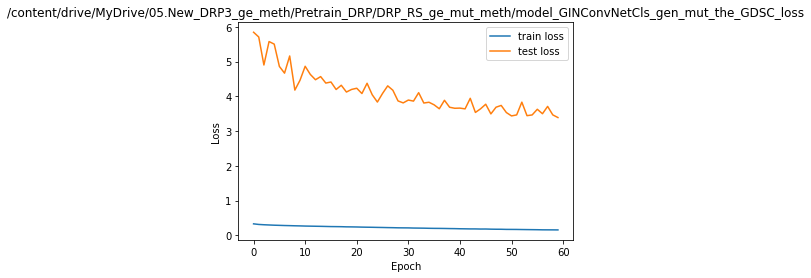

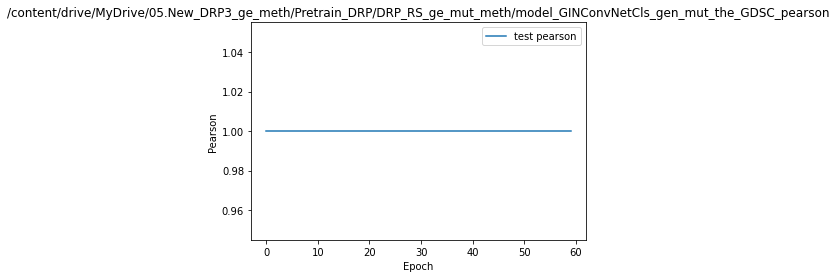

In [14]:
main(model, train_batch, val_batch, test_batch, lr, num_epoch, log_interval)

In [15]:
data_path = "/content/drive/MyDrive/05.New_DRP3_ge_meth/MOLI/preprocess/processed_ge_mut_meth/" # data to process
pretrain_cls = "/content/drive/MyDrive/05.New_DRP3_ge_meth/Pretrain_DRP/DRP_RS_ge_mut_meth/model_GINConvNetCls_gen_mut_the_GDSC.model"
model.load_state_dict(torch.load(pretrain_cls))


<All keys matched successfully>

In [16]:
GDSC_Docetaxel_test_mix = TestbedDataset(root=data_path, dataset="GDSC_Docetaxel_test_mix")
GDSC_Erlotinib_test_mix = TestbedDataset(root=data_path, dataset="GDSC_Erlotinib_test_mix")
GDSC_Gemcitabine_test_mix = TestbedDataset(root=data_path, dataset="GDSC_Gemcitabine_test_mix")
GDSC_Paclitaxel_test_mix = TestbedDataset(root=data_path, dataset="GDSC_Paclitaxel_test_mix")

GDSC_Docetaxel_test_mix = DataLoader(GDSC_Docetaxel_test_mix, batch_size=test_batch, shuffle=False)
GDSC_Erlotinib_test_mix = DataLoader(GDSC_Erlotinib_test_mix, batch_size=test_batch, shuffle=False)
GDSC_Gemcitabine_test_mix = DataLoader(GDSC_Gemcitabine_test_mix, batch_size=test_batch, shuffle=False)
GDSC_Paclitaxel_test_mix = DataLoader(GDSC_Paclitaxel_test_mix, batch_size=test_batch, shuffle=False)
bce = nn.BCELoss()
test_loaders = [GDSC_Docetaxel_test_mix, GDSC_Erlotinib_test_mix, GDSC_Gemcitabine_test_mix, GDSC_Paclitaxel_test_mix]
for test_loader in test_loaders:
  G_test,P_test = predicting(model, device, test_loader)
  ret_test = [roc_auc_score(G_test,P_test),bce(G_test,P_test),pearson(G_test,P_test),spearman(G_test,P_test)]
  print(ret_test)
  print("_________________________________________________________________________________________________")

Pre-processed data found: /content/drive/MyDrive/05.New_DRP3_ge_meth/MOLI/preprocess/processed_ge_mut_meth/processed/GDSC_Docetaxel_test_mix.pt, loading ...
Pre-processed data found: /content/drive/MyDrive/05.New_DRP3_ge_meth/MOLI/preprocess/processed_ge_mut_meth/processed/GDSC_Erlotinib_test_mix.pt, loading ...
Pre-processed data found: /content/drive/MyDrive/05.New_DRP3_ge_meth/MOLI/preprocess/processed_ge_mut_meth/processed/GDSC_Gemcitabine_test_mix.pt, loading ...
Pre-processed data found: /content/drive/MyDrive/05.New_DRP3_ge_meth/MOLI/preprocess/processed_ge_mut_meth/processed/GDSC_Paclitaxel_test_mix.pt, loading ...
Make prediction for 138 samples...
[0.74140625, tensor(2.8968), 0.9999999999999999, array([[ 1.        , -1.        ,  0.21680856, -0.21731225],
       [-1.        ,  1.        , -0.21680856,  0.21731225],
       [ 0.21680856, -0.21680856,  1.        , -0.99768219],
       [-0.21731225,  0.21731225, -0.99768219,  1.        ]])]
_______________________________________

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [31]:
for epoch in range(num_epoch):
  train_loss = train(model, device, train_loader, optimizer, epoch+1, log_interval)
  G,P = predicting(model, device, val_loader)
  # G,P = predicting(model, device, test_loader)

  ret = [roc_auc_score(G,P),bce(G,P),pearson(G,P),spearman(G,P)]
              
  G_test,P_test = predicting(model, device, test_loader)
  ret_test = [roc_auc_score(G_test,P_test),bce(G_test,P_test),pearson(G_test,P_test),spearman(G_test,P_test)]

  train_losses.append(train_loss)
  val_losses.append(ret[1])
  val_pearsons.append(ret[2])

  if ret[1]<best_bce:
      torch.save(model.state_dict(), model_file_name)
      with open(result_file_name,'w') as f:
          f.write(','.join(map(str,ret_test)))
      best_epoch = epoch+1
      best_bce = ret[1]
      best_pearson = ret[2]
      best_auc = ret[0]
      best_ret_test = ret_test

      print(' bce improved at epoch ', best_epoch, '; best_bce:', best_bce,model_st,dataset, "; best_auc:", best_auc)
  else:
      print(' no improvement since epoch ', best_epoch, '; best_bce, best pearson:', best_bce, best_pearson, model_st, dataset, "; best_auc:", best_auc)
draw_loss(train_losses, val_losses, loss_fig_name)
draw_pearson(val_pearsons, pearson_fig_name)
print(best_ret_test)

NameError: ignored